# Imports

In [1]:
import requests
import pandas as pd
import math
import datetime
import urllib.request
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

## Retrieve Open Buffalo Data
<a id='open_buffalo_api_request'></a>

In [2]:
#hide api ket in text file so its not public
app_token = open('api_key.txt', 'r').read()
#app_token

In [3]:
#hide api token
#use request to pull 311 data from Jan 01, 2020 until today / can slice data in pandas later
limit = 500000
app_token = open('api_key.txt', 'r').read()
uri = f"https://data.buffalony.gov/resource/whkc-e5vr.json?$limit={limit}&$$app_token={app_token}&$where=open_date>'2020-01-10T12:00:00'"
r = requests.get(uri)
print('Status code ',r.status_code)
print('Number of rows returned ',len(r.json()))
print('Endoced URI with params ',r.url)
new_json = r.json()
#new_json

Status code  200
Number of rows returned  277742
Endoced URI with params  https://data.buffalony.gov/resource/whkc-e5vr.json?$limit=500000&$$app_token=NnGV0W4ip4YEFBLvBMGAjaByD&$where=open_date%3E'2020-01-10T12:00:00'


In [4]:
#make pandas df from  json / check head
df=pd.DataFrame(new_json)
print(df.shape)
df.head(2)

(277742, 33)


case_reference                open_date              closed_date  status  \
0     1001109603  2020-01-10T12:02:00.000  2020-01-22T13:35:00.000  Closed   
1     1001109605  2020-01-10T12:07:00.000  2020-01-14T13:28:00.000  Closed   

                subject          reason                               type  \
0  Dept of Public Works      Sanitation  Recycling Tote Deliver (Req_Serv)   
1  Dept of Public Works  Rodent Control                 Rodents (Req_Serv)   

  object_type address_number address_line_1  ... census_tract_2010  \
0    Property            420       PARKDALE  ...               171   
1    Property             92        PROCTOR  ...                41   

  census_block_group_2010 census_block_2010 tractce20 geoid20_tract  \
0                       2              2000    017100   36029017100   
1                       2              2002    004100   36029004100   

  geoid20_blockgroup    geoid20_block address_line_2 x_coordinate y_coordinate  
0       360290171002  360290171002000            NaN          NaN          NaN  
1       360290041002  360290041002002            NaN          NaN          NaN  

[2 rows x 33 columns]

In [5]:
#save original Buffalo 311 Data to csv
df.to_csv('Buffalo311Data.csv', index = None, header=True)

## Format Open Buffalo Data Dates
<a id='format_open_buffalo_data'></a>

In [6]:
#add count column with a value of one to rows to count calls by frequency
df['count'] = 1
#df.head()

In [7]:
#format open date to pd datetime to get ready to parse column
df['time'] = pd.to_datetime(df['open_date'])
#df.info() #check to make sure Dtype is datetime64

In [8]:
#take a look at teh columns I need
#parsing by hour will provide 24 times more training data than doing it by day
df1 = df[['time', 'count']]
df1.head(3)

time  count
0 2020-01-10 12:02:00      1
1 2020-01-10 12:07:00      1
2 2020-01-10 12:08:00      1

#### parsing by hour will provide 24 times more training data than doing it by day
#### I beleive that would equate to needing an extra six years of training data if I did it by day
#### If I am only testing since the start of 2023 and projecting roughly seven months
#### I think it is better to train on granular data rather than daily data going back an extra six years
#### I feel like the more recent the training data, especially after covid the better the results will yield

In [10]:
#use date time to parse by year
df1['time'] = pd.to_datetime(df1['time']).dt.strftime('%Y-%m-%d %H')
df1.head()

time  count
0  2020-01-10 12      1
1  2020-01-10 12      1
2  2020-01-10 12      1
3  2020-01-10 12      1
4  2020-01-10 12      1

In [11]:
#group by hour, count and reset index
df2 = df1.groupby(['time']).count().reset_index()

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18336 entries, 0 to 18335
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    18336 non-null  object
 1   count   18336 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 286.6+ KB


In [13]:
#make sure time is pd datetime after groupby. seems to create new object after groupby
df2['time'] = pd.to_datetime(df2['time'])

In [14]:
#set time as index
df2 = df2.set_index('time')

In [15]:
#df2.head()

In [16]:
#make df by day instead of hour for some charts
#ultimatly decided to use hourly because I feel it would help for staffing and letting people go home early 
df_day = df1.copy()

In [17]:
df_day['time'] = pd.to_datetime(df_day['time']).dt.strftime('%Y-%m-%d')
df_day = df_day.groupby(['time']).count().reset_index()
df_day['time'] = pd.to_datetime(df_day['time'])
df_day = df_day.set_index('time')


In [18]:
#df_day.head()

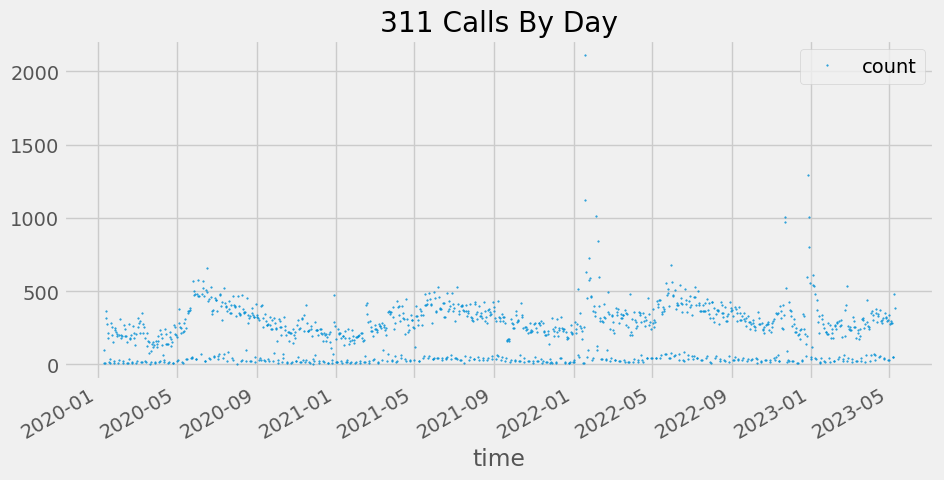

In [19]:
#make graph of calls by day
color_pal = sns.color_palette()
df_day.plot(style='.',
         figsize=(10,5),
         ms=1,
         color = color_pal[0],
         title='311 Calls By Day')
plt.show()

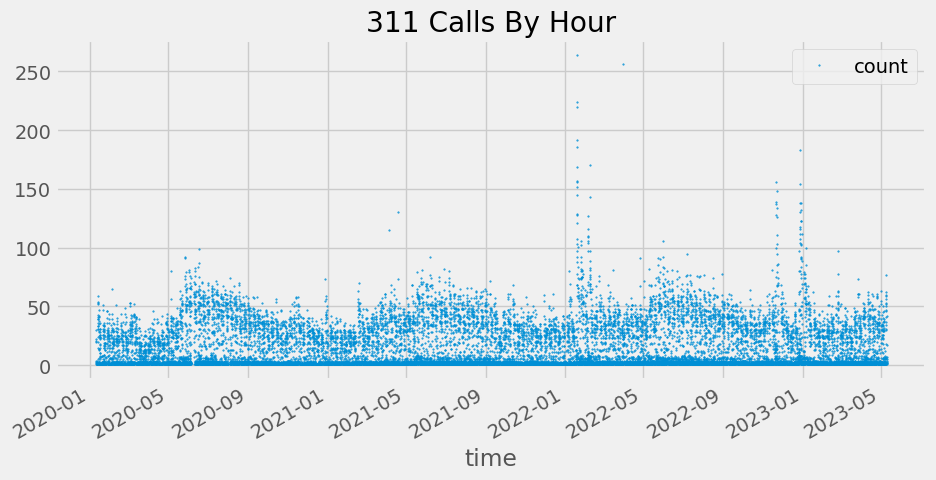

In [20]:
#make graph of call by hour
color_pal = sns.color_palette()
df2.plot(style='.',
         figsize=(10,5),
         ms=1,
         color = color_pal[0],
         title='311 Calls By Hour')
plt.show()

In [21]:
#create seasons for boxplot graph showing dayofweek and season
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday',
                                       'Wednesday', 'Thursday',
                                       'Friday', 'Saturday', 'Sunday'],
                           ordered=True)




def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    #df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    
    df['season'] = pd.cut(df['date_offset'], [0, 300, 600, 900, 1300],
                         labels=['Spring', 'Summer', 'Fall', 'Winter'])


    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear', 'weekday', 'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_day, label='count')

features_and_target = pd.concat([X, y], axis=1)

In [22]:
features_and_target.head()

dayofweek  quarter  month  year  dayofyear  dayofmonth  \
time                                                                 
2020-01-10          4        1      1  2020         10          10   
2020-01-11          5        1      1  2020         11          11   
2020-01-12          6        1      1  2020         12          12   
2020-01-13          0        1      1  2020         13          13   
2020-01-14          1        1      1  2020         14          14   

            weekofyear   weekday  season  count  
time                                             
2020-01-10           2    Friday  Winter     98  
2020-01-11           2  Saturday  Winter     12  
2020-01-12           2    Sunday  Winter     13  
2020-01-13           3    Monday  Winter    368  
2020-01-14           3   Tuesday  Winter    316

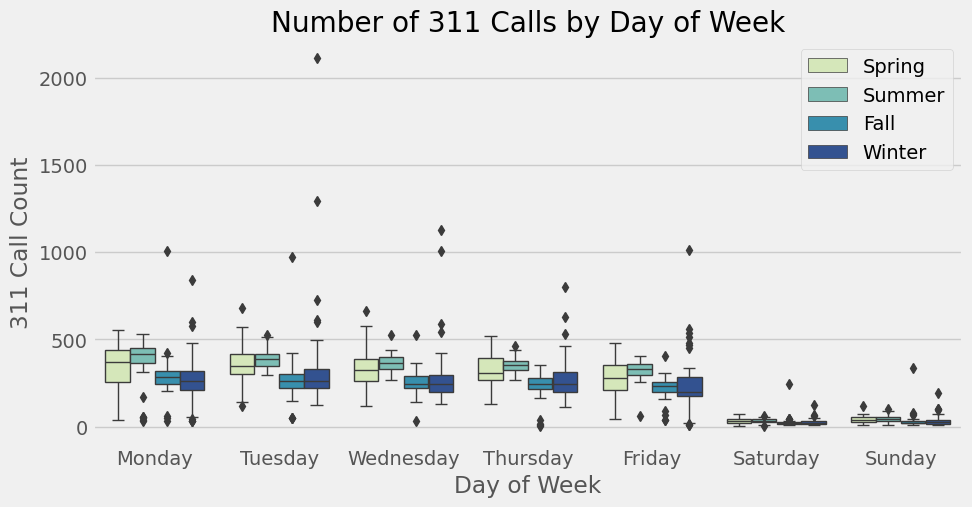

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target.dropna(),
           x='weekday',
           y='count',
           hue='season',
           ax = ax,
           linewidth=1,
           palette='YlGnBu')

ax.set_title('Number of 311 Calls by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('311 Call Count')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

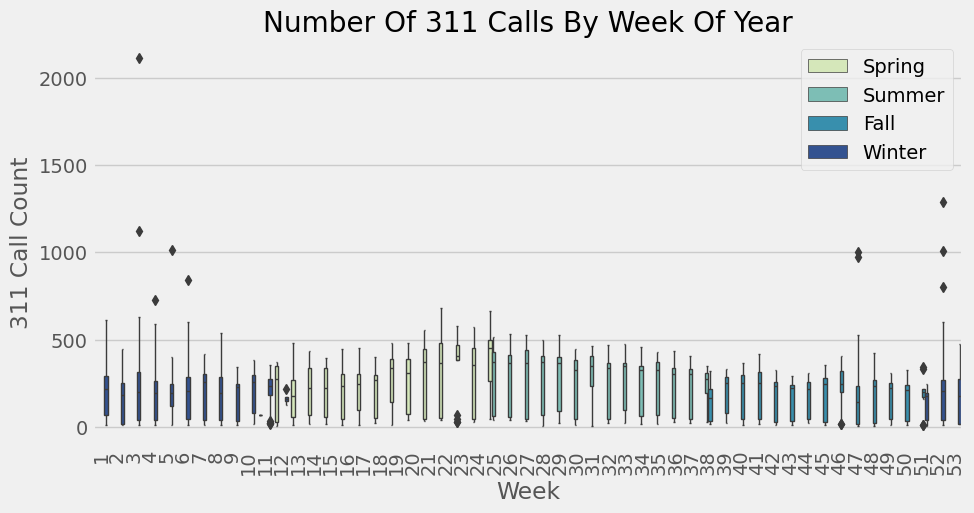

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target.dropna(),
           x='weekofyear',
           y='count',
           hue='season',
           ax = ax,
           linewidth=1,
           palette='YlGnBu')

ax.set_title('Number Of 311 Calls By Week Of Year')
ax.set_xlabel('Week')
ax.set_ylabel('311 Call Count')
plt.xticks(rotation = 90) # rotates x-axis by 45 degrees
ax.legend(bbox_to_anchor=(1,1))
plt.show()

### Group data by hour and see what the call volume is and group data by week

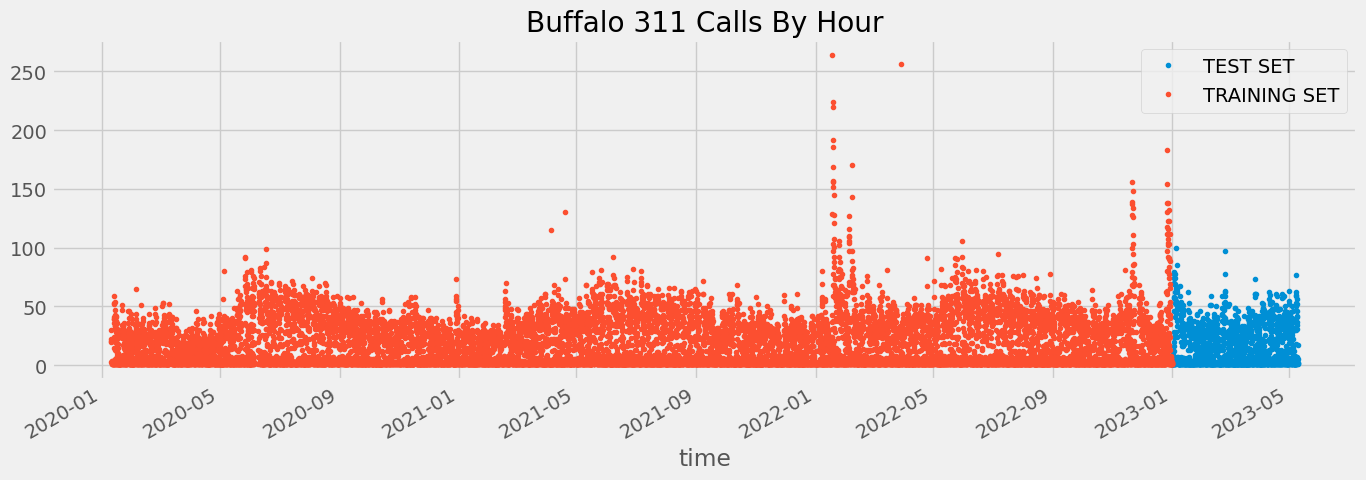

In [25]:
split_date = '1-jan-2023'
df_train = df2.loc[df2.index <= split_date].copy()
df_test = df2.loc[df2.index > split_date].copy()

# plot train and test so you can see where the split is

df_test \
    .rename(columns={'count': 'TEST SET'}) \
    .join(df_train.rename(columns={'count': 'TRAINING SET'}),
         how='outer') \
    .plot(figsize=(15,5), title='Buffalo 311 Calls By Hour', style='.')
plt.show()

Train Prophet model
datetime column named ds
target = y

In [26]:
#format data for prophet model using ds and y
df_train_prophet = df_train.reset_index()\
    .rename(columns={'time': 'ds',
                    'count': 'y'})

In [27]:
df_train_prophet.head()

ds   y
0 2020-01-10 12:00:00  21
1 2020-01-10 13:00:00  20
2 2020-01-10 14:00:00  22
3 2020-01-10 15:00:00  30
4 2020-01-10 16:00:00   3

In [28]:
%%time
model = Prophet()
model.fit(df_train_prophet)

15:18:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:07 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 1.42 s
Wall time: 9.67 s


In [29]:
%%time
# create test dat with same column names
df_test_prophet = df_test.reset_index()\
    .rename(columns={'time': 'ds',
                    'count': 'y'})

df_test_fcst = model.predict(df_test_prophet)

CPU times: total: 2.02 s
Wall time: 541 ms


In [30]:
df_test_fcst.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2023-01-01 01:00:00  19.038017  -18.082230   16.134619    19.038017   
1 2023-01-01 03:00:00  19.041680  -16.196708   16.441544    19.041680   
2 2023-01-01 07:00:00  19.049007  -16.467086   17.694639    19.049007   
3 2023-01-01 08:00:00  19.050838   -1.699195   31.412708    19.050838   
4 2023-01-01 09:00:00  19.052670    7.991571   42.268996    19.052670   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    19.038017      -20.199082            -20.199082            -20.199082   
1    19.041680      -18.544646            -18.544646            -18.544646   
2    19.049007      -18.550251            -18.550251            -18.550251   
3    19.050838       -4.490101             -4.490101             -4.490101   
4    19.052670        6.905000              6.905000              6.905000   

       daily  ...     weekly  weekly_lower  weekly_upper    yearly  \
0  -6.409008  ... -14.649280    -14.649280    -14.649280  0.859206   
1  -5.126092  ... -14.317852    -14.317852    -14.317852  0.899298   
2  -6.533164  ... -12.996319    -12.996319    -12.996319  0.979233   
3   7.049725  ... -12.538989    -12.538989    -12.538989  0.999163   
4  17.921719  ... -12.035792    -12.035792    -12.035792  1.019073   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.859206      0.859206                   0.0   
1      0.899298      0.899298                   0.0   
2      0.979233      0.979233                   0.0   
3      0.999163      0.999163                   0.0   
4      1.019073      1.019073                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0  -1.161066  
1                         0.0                         0.0   0.497034  
2                         0.0                         0.0   0.498756  
3                         0.0                         0.0  14.560738  
4                         0.0                         0.0  25.957670  

[5 rows x 22 columns]

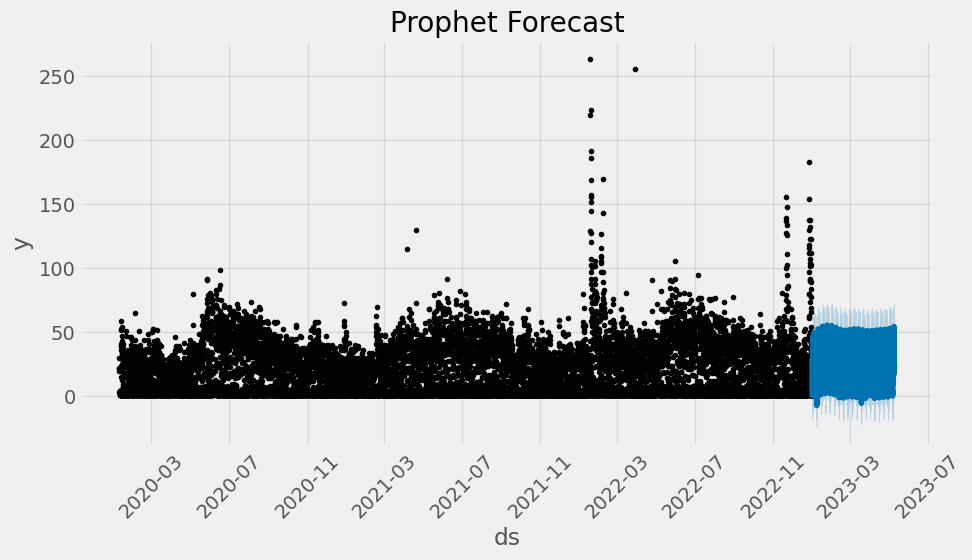

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(df_test_fcst, ax= ax)
plt.xticks(rotation = 45) # rotates x-axis by 45 degrees
ax.set_title('Prophet Forecast')
plt.show()

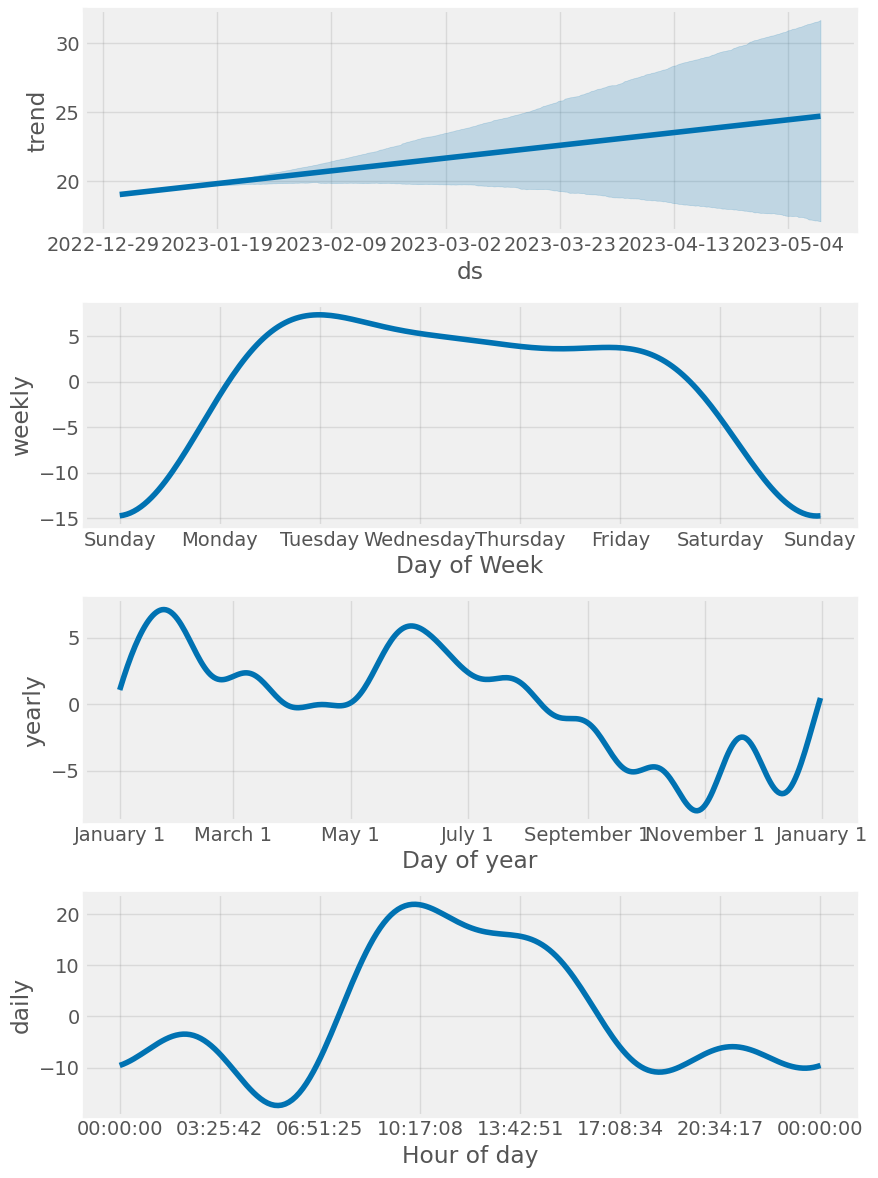

In [34]:
fig = model.plot_components(df_test_fcst)
plt.show()

### Compare Forecast to Actuals

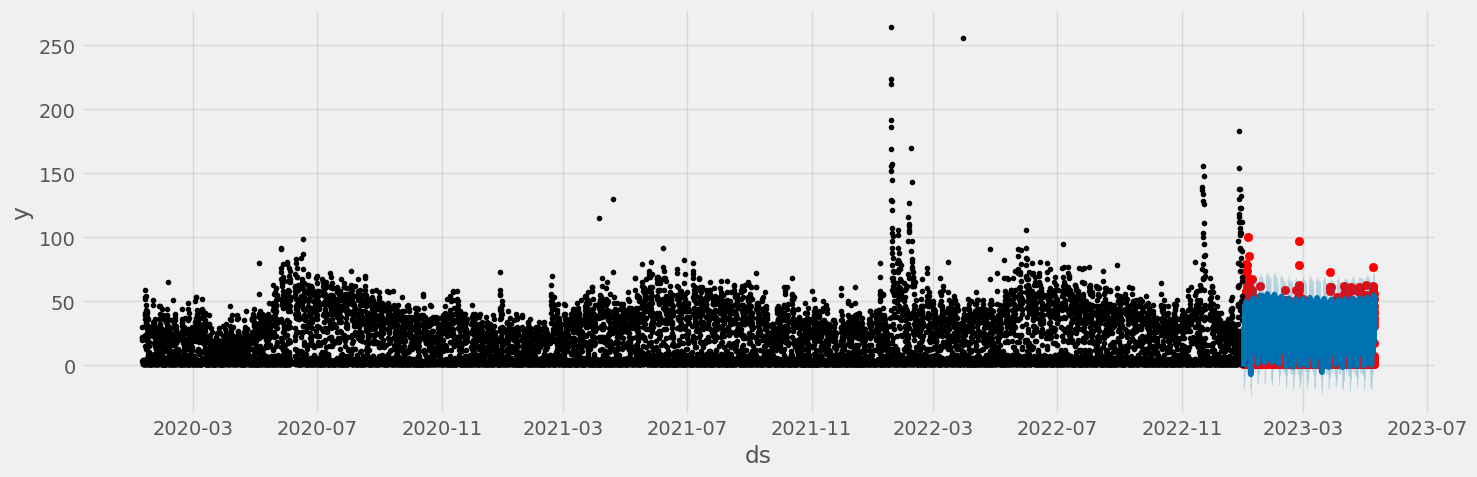

In [35]:
#plot teh forecast with the actual
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(df_test.index, df_test['count'], color ='r')
fig = model.plot(df_test_fcst, ax= ax)

### Zoom into actual vs predicted
RED DOTS ARE ACTUAL/ BLUE LINES ARE PREDICTIONS
/nseems like there is a mismatch between actual and predicted probably due to people waiting to call 311 until after the holidays.

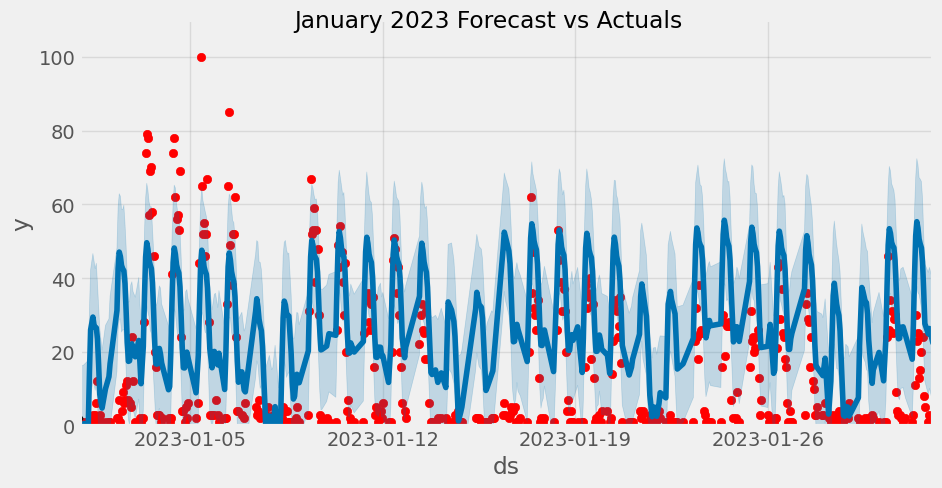

In [36]:
#zoomed in plot of forecast vs actual
import datetime

f, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_test.index, df_test['count'], color ='r')
fig = model.plot(df_test_fcst, ax= ax)
# ax.set_xbound(lower='01-01-2015',
#              upper='02-01-2015')
ax.set_xlim([datetime.date(2023, 1, 1), datetime.date(2023, 2, 1)])
ax.set_ylim(0,110)
plot = plt.suptitle('January 2023 Forecast vs Actuals')

### Zoom into first week of jan / Blizzard affected call projections
Seems like the 2023 Blizard caused more calls than predicted especially when you compare to the first week of April

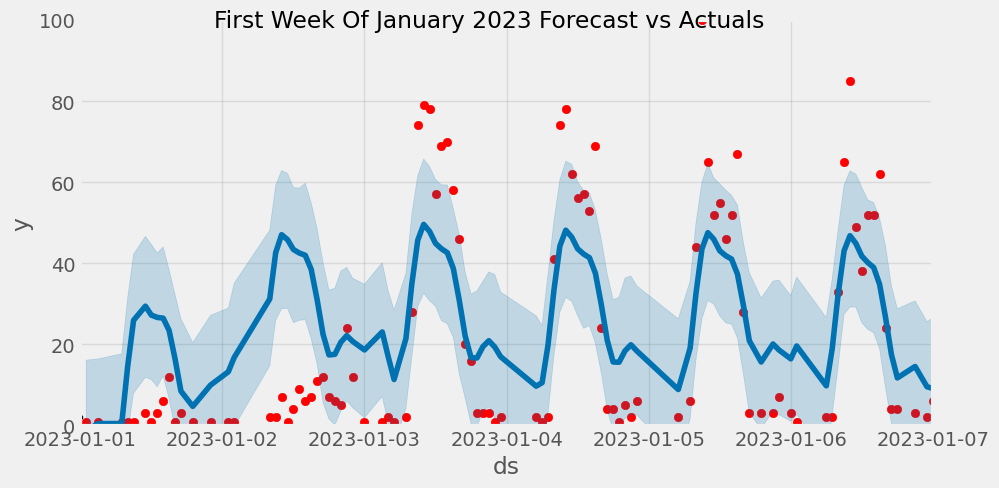

In [37]:
#zoomed in plot of forecast vs actual
import datetime

f, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_test.index, df_test['count'], color ='r')
fig = model.plot(df_test_fcst, ax= ax)
# ax.set_xbound(lower='01-01-2015',
#              upper='02-01-2015')
ax.set_xlim([datetime.date(2023, 1, 1), datetime.date(2023, 1, 7)])
ax.set_ylim(0,100)
plot = plt.suptitle('First Week Of January 2023 Forecast vs Actuals')

### Zoom Into First Week Of April 2023
###### Aprils predcition is looking better than the first week of Jan
###### Outliers in first week of Jan are most likly from the Blizzard

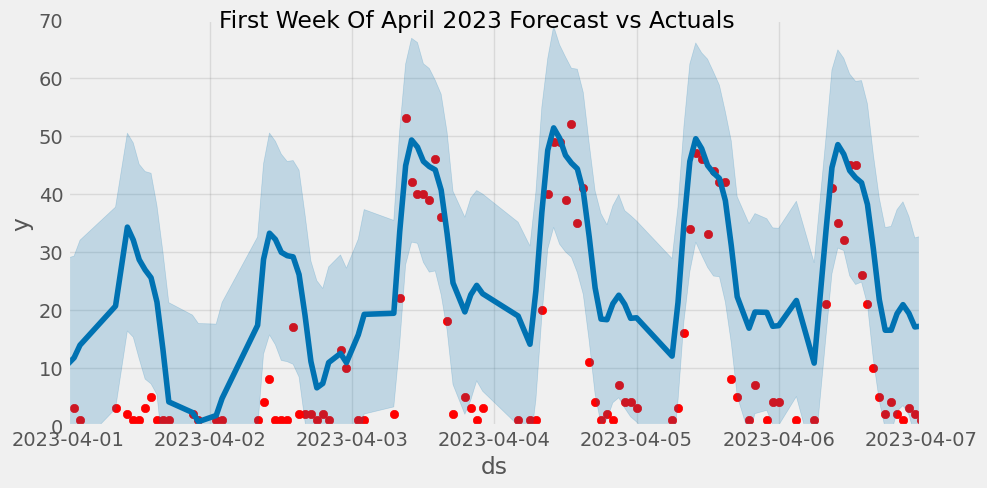

In [38]:
#zoomed in plot of forecast vs actual
import datetime

f, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_test.index, df_test['count'], color ='r')
fig = model.plot(df_test_fcst, ax= ax)
# ax.set_xbound(lower='01-01-2015',
#              upper='02-01-2015')
ax.set_xlim([datetime.date(2023, 4, 1), datetime.date(2023, 4, 7)])
ax.set_ylim(0,70)
plot = plt.suptitle('First Week Of April 2023 Forecast vs Actuals')

# evaluate the model with Error Metrics

In [39]:
# true value vs predicted value
np.sqrt(mean_squared_error(y_true=df_test['count'],
                          y_pred=df_test_fcst['yhat']))

18.53331967782901

In [40]:
mean_absolute_error(y_true=df_test['count'],
                   y_pred=df_test_fcst['yhat'])

16.444075387619147

# Adding Holidays To Prophet Model

In [49]:
# set up holiday dataframe
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=df2.index.min(),
                        end=df2.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [50]:
holiday_df.head()

ds                              holiday
0 2020-01-20  Birthday of Martin Luther King, Jr.
1 2020-02-17                Washington’s Birthday
2 2020-05-25                         Memorial Day
3 2020-07-03                     Independence Day
4 2020-09-07                            Labor Day

In [51]:
holiday_df['holiday'].value_counts()

Birthday of Martin Luther King, Jr.     4
Washington’s Birthday                   4
Memorial Day                            3
Independence Day                        3
Labor Day                               3
Columbus Day                            3
Veterans Day                            3
Thanksgiving Day                        3
Christmas Day                           3
New Year's Day                          3
Juneteenth National Independence Day    2
Name: holiday, dtype: int64

In [56]:
import time

In [58]:
#run Prophet model with holiday df as a parameter for holiday
#%%time

model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(df_train_prophet)

15:35:23 - cmdstanpy - INFO - Chain [1] start processing
15:35:31 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
# predict on training set with model
df_test_fcst_with_hols = model_with_holidays.predict(df=df_test_prophet)

In [60]:
df_test_fcst_with_hols.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2023-01-01 01:00:00  19.962327  -17.298810   16.125482    19.962327   
1 2023-01-01 03:00:00  19.966306  -15.429744   17.809987    19.966306   
2 2023-01-01 07:00:00  19.974263  -15.194841   17.696200    19.974263   
3 2023-01-01 08:00:00  19.976252   -0.710243   32.056320    19.976252   
4 2023-01-01 09:00:00  19.978242   10.426556   42.368802    19.978242   

   trend_upper  Birthday of Martin Luther King, Jr.  \
0    19.962327                                  0.0   
1    19.966306                                  0.0   
2    19.974263                                  0.0   
3    19.976252                                  0.0   
4    19.978242                                  0.0   

   Birthday of Martin Luther King, Jr._lower  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   Birthday of Martin Luther King, Jr._upper  Christmas Day  ...     weekly  \
0                                        0.0            0.0  ... -15.474464   
1                                        0.0            0.0  ... -15.147649   
2                                        0.0            0.0  ... -13.741419   
3                                        0.0            0.0  ... -13.242802   
4                                        0.0            0.0  ... -12.690424   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0    -15.474464    -15.474464  1.114713      1.114713      1.114713   
1    -15.147649    -15.147649  1.160615      1.160615      1.160615   
2    -13.741419    -13.741419  1.251959      1.251959      1.251959   
3    -13.242802    -13.242802  1.274699      1.274699      1.274699   
4    -12.690424    -12.690424  1.297399      1.297399      1.297399   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  -0.726449  
1                         0.0   0.815920  
2                         0.0   0.869277  
3                         0.0  15.025595  
4                         0.0  26.507473  

[5 rows x 58 columns]

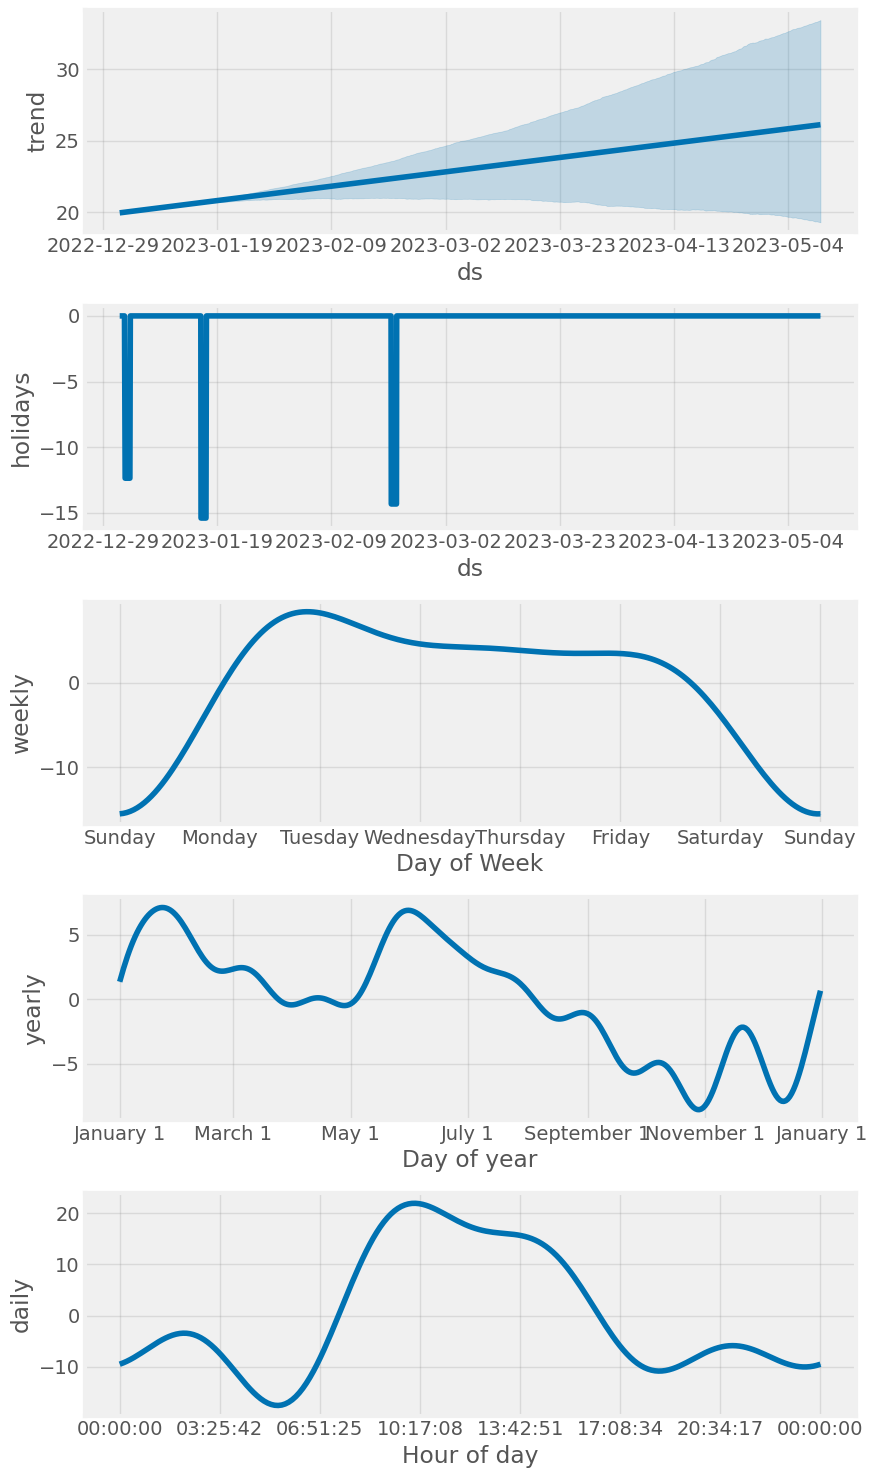

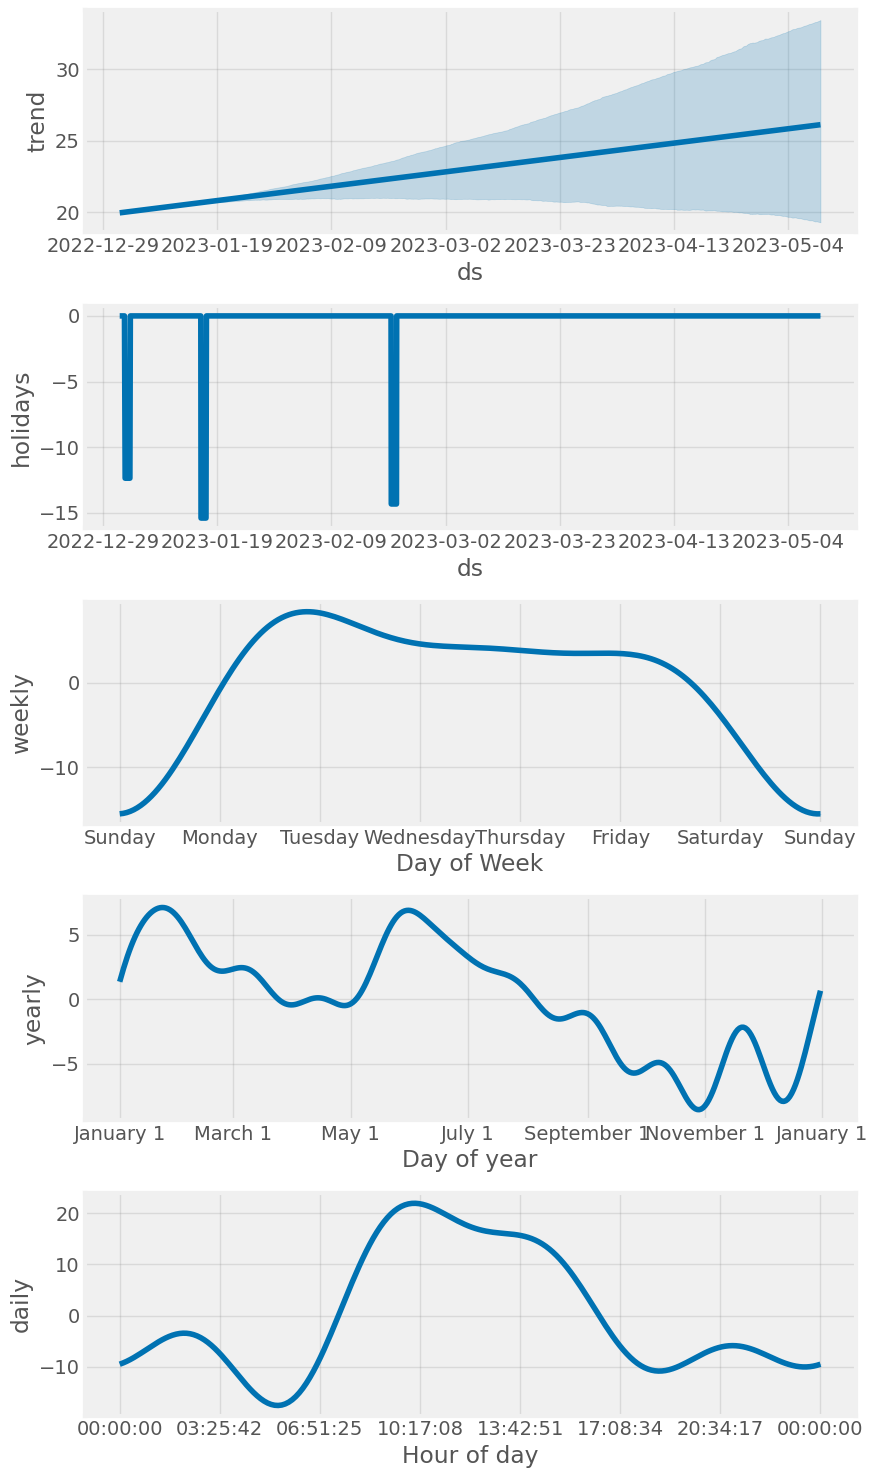

In [61]:
model_with_holidays.plot_components(
    df_test_fcst_with_hols)

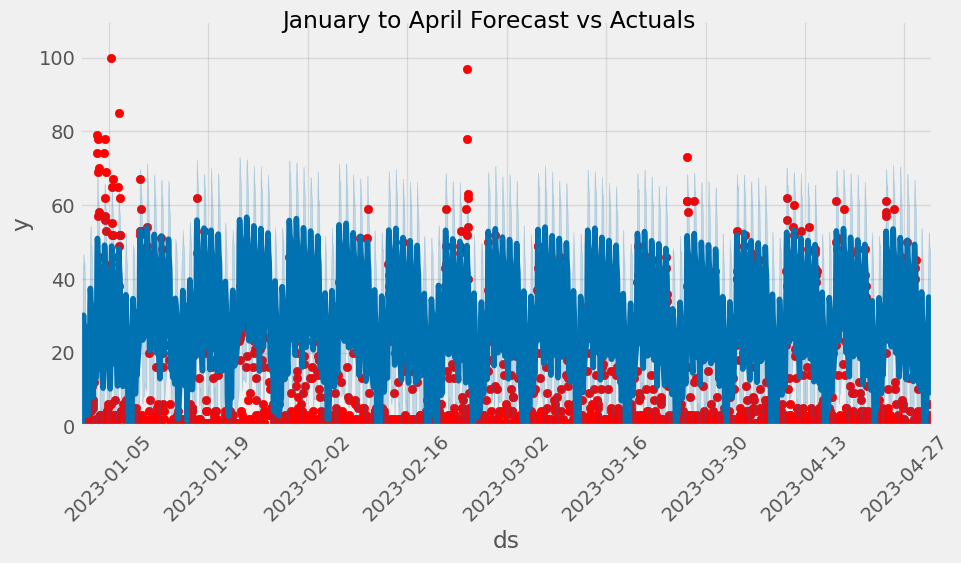

In [62]:
#zoomed in plot of forecast vs actual

# red dots show actual vs projected line in blue
import datetime

f, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_test.index, df_test['count'], color ='r')
fig = model.plot(df_test_fcst_with_hols, ax= ax)
# ax.set_xbound(lower='07-01-2015',
#              upper='07-07-2015')
ax.set_xlim([datetime.date(2023, 1, 1), datetime.date(2023, 5, 1)])
ax.set_ylim(0,110)
plt.xticks(rotation = 45) # rotates x-axis by 45 degrees
plot = plt.suptitle('January to April Forecast vs Actuals')

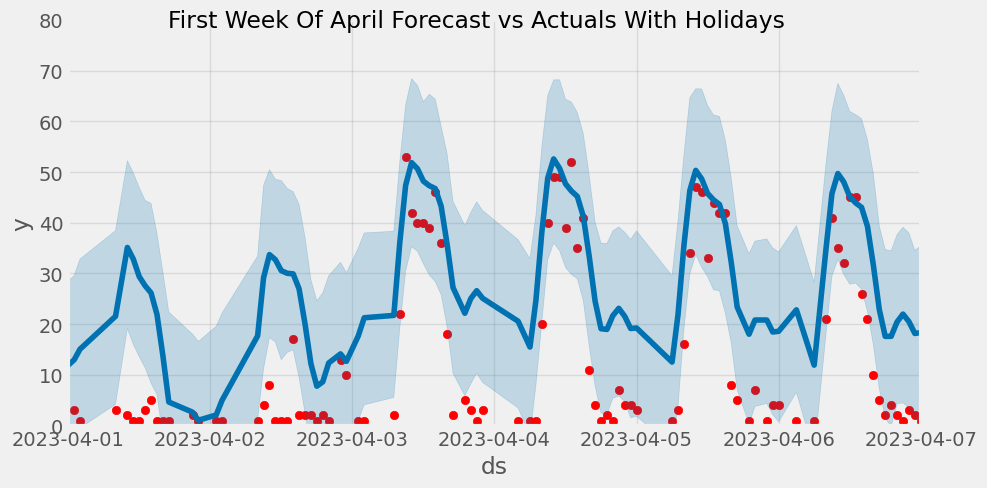

In [63]:
#zoomed in plot of forecast vs actual
import datetime

f, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_test.index, df_test['count'], color ='r')
fig = model.plot(df_test_fcst_with_hols, ax= ax)
# ax.set_xbound(lower='07-01-2015',
#              upper='07-07-2015')
ax.set_xlim([datetime.date(2023, 4, 1), datetime.date(2023, 4, 7)])
ax.set_ylim(0,80)
plot = plt.suptitle('First Week Of April Forecast vs Actuals With Holidays')

In [64]:
# true value vs predicted value
np.sqrt(mean_squared_error(y_true=df_test['count'],
                          y_pred=df_test_fcst_with_hols['yhat']))

19.14157031066351

In [65]:
mean_absolute_error(y_true=df_test['count'],
                   y_pred=df_test_fcst_with_hols['yhat'])

17.139861907579142

# Predict into the future

In [66]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)

In [67]:
forecast = model_with_holidays.predict(future)

In [68]:
forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2023-01-01 01:00:00  19.962327  -16.882693   15.841012    19.962327   
1 2023-01-01 02:00:00  19.964316  -12.946475   17.548705    19.964316   
2 2023-01-01 03:00:00  19.966306  -14.783082   17.679284    19.966306   
3 2023-01-01 04:00:00  19.968295  -21.090066   11.068481    19.968295   
4 2023-01-01 05:00:00  19.970284  -28.096313    3.966954    19.970284   

   trend_upper  Birthday of Martin Luther King, Jr.  \
0    19.962327                                  0.0   
1    19.964316                                  0.0   
2    19.966306                                  0.0   
3    19.968295                                  0.0   
4    19.970284                                  0.0   

   Birthday of Martin Luther King, Jr._lower  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   Birthday of Martin Luther King, Jr._upper  Christmas Day  ...     weekly  \
0                                        0.0            0.0  ... -15.474464   
1                                        0.0            0.0  ... -15.343241   
2                                        0.0            0.0  ... -15.147649   
3                                        0.0            0.0  ... -14.888335   
4                                        0.0            0.0  ... -14.566408   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0    -15.474464    -15.474464  1.114713      1.114713      1.114713   
1    -15.343241    -15.343241  1.137683      1.137683      1.137683   
2    -15.147649    -15.147649  1.160615      1.160615      1.160615   
3    -14.888335    -14.888335  1.183508      1.183508      1.183508   
4    -14.566408    -14.566408  1.206364      1.206364      1.206364   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  -0.726449  
1                         0.0   2.207288  
2                         0.0   0.815920  
3                         0.0  -4.982981  
4                         0.0 -10.279008  

[5 rows x 58 columns]

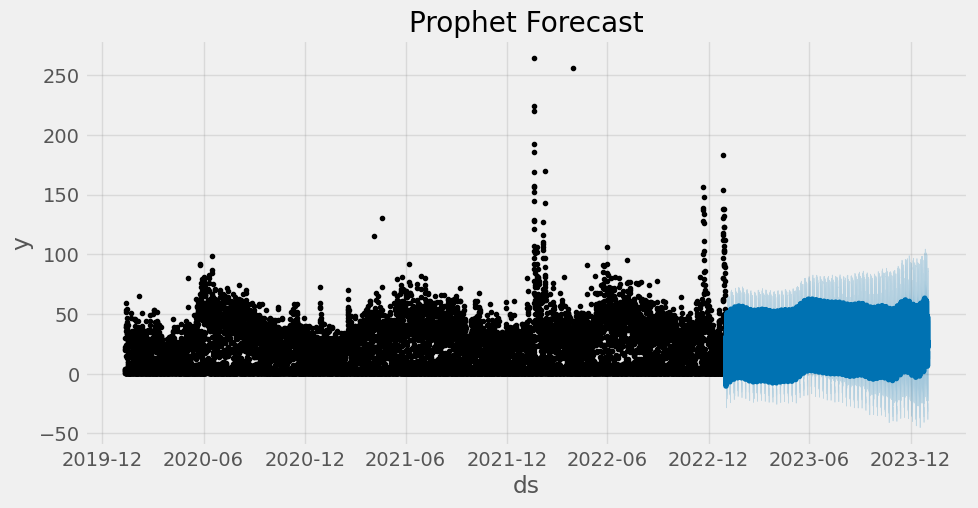

In [69]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(forecast, ax= ax)
ax.set_title('Prophet Forecast')
plt.show()

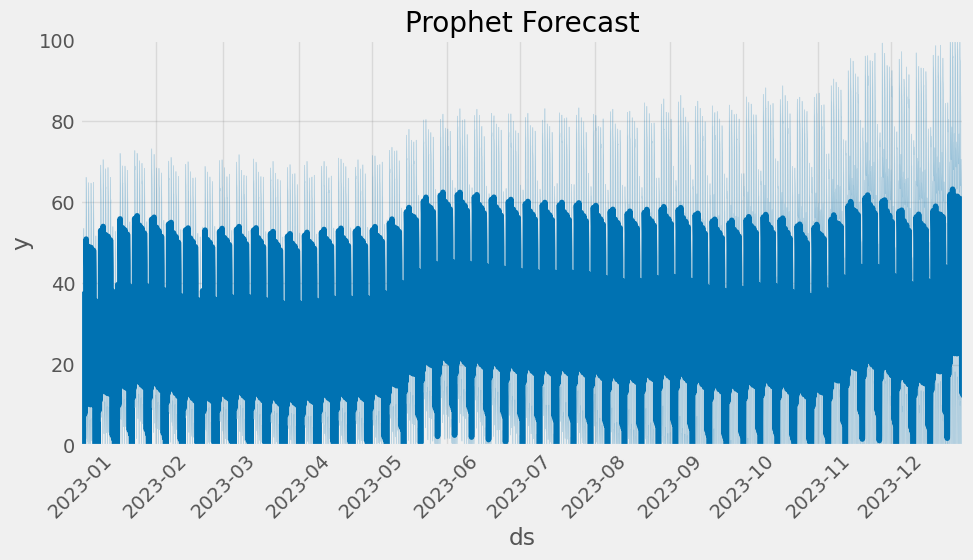

In [70]:
#zoomed in plot of forecast
import datetime

fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(forecast, ax= ax)
ax.set_xlim([datetime.date(2023, 1, 1), datetime.date(2023, 12, 31)])
ax.set_ylim(0,100)
plt.xticks(rotation = 45) # rotates x-axis by 45 degrees
ax.set_title('Prophet Forecast')
plt.show()



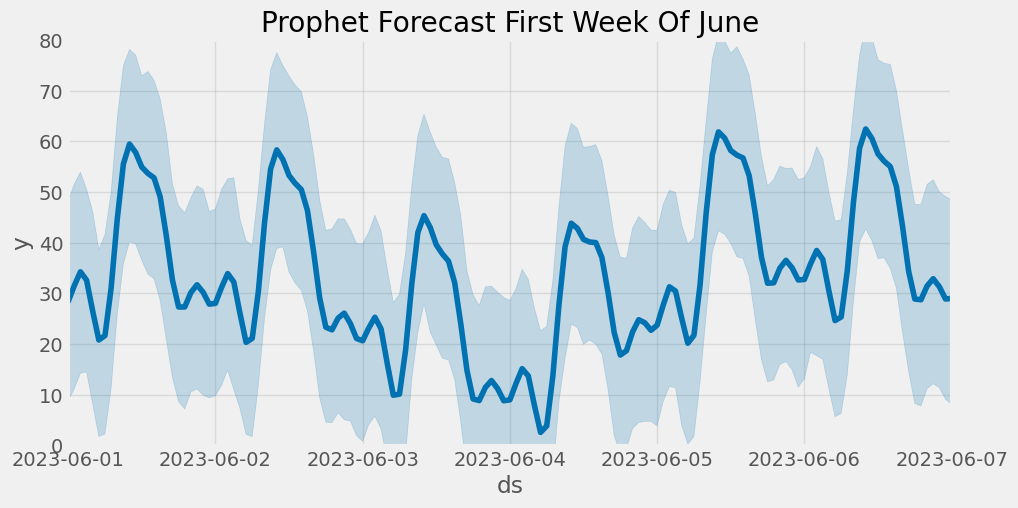

In [72]:
#zoomed in plot of forecast for upcoming week; first week of may
import datetime

fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(forecast, ax= ax)
ax.set_xlim([datetime.date(2023, 6, 1), datetime.date(2023, 6, 7)])
ax.set_ylim(0,80)
ax.set_title('Prophet Forecast First Week Of June')
plt.show()

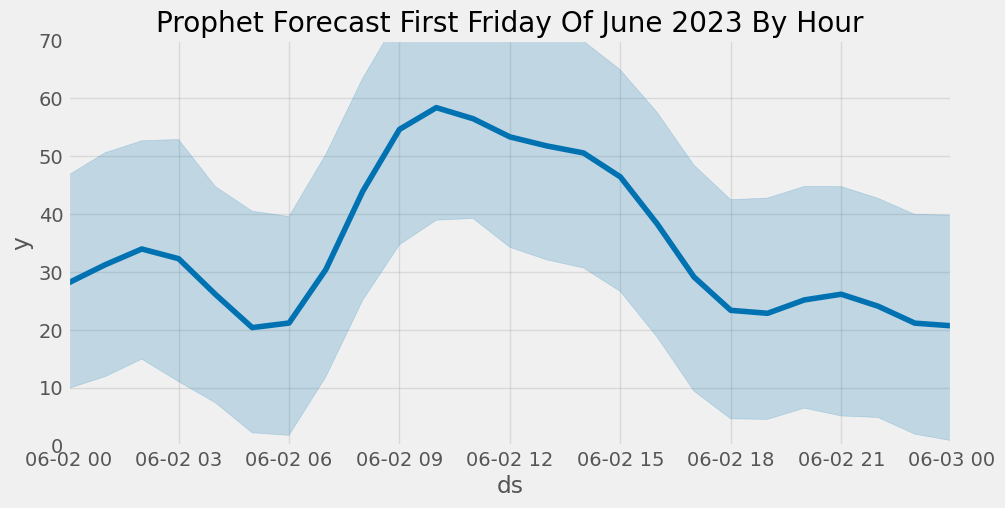

In [73]:
#zoomed in plot of forecast for upcoming Friday; first firday of june
import datetime

fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(forecast, ax= ax)
ax.set_xlim([datetime.date(2023, 6, 2), datetime.date(2023, 6, 3)])
ax.set_ylim(0,70)
ax.set_title('Prophet Forecast First Friday Of June 2023 By Hour')
plt.show()

The graph above shows a peak call time between 9am and 3pm friday June 2nd

### XGBOOST Forecasting

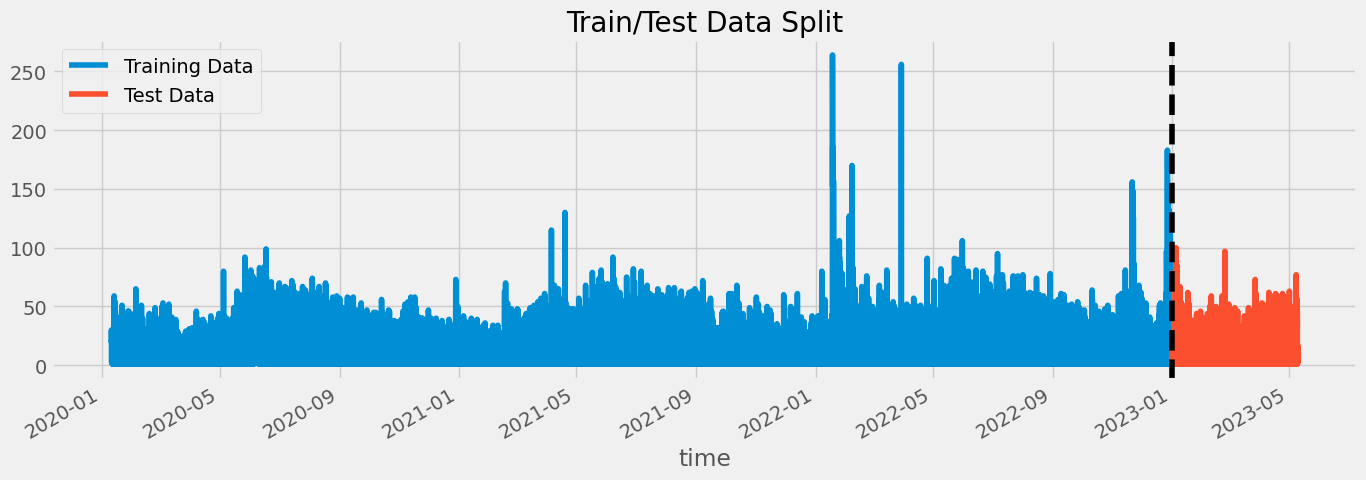

In [74]:
split_date = '1-jan-2023'
df_train2 = df2.loc[df2.index <= split_date].copy()
df_test2 = df2.loc[df2.index > split_date].copy()

fig, ax = plt.subplots(figsize=(15,5))
df_train2.plot(ax=ax, label='Training Data', title='Train/Test Data Split')
df_test2.plot(ax=ax, label='Testing Data')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Data', 'Test Data'])
plt.show()

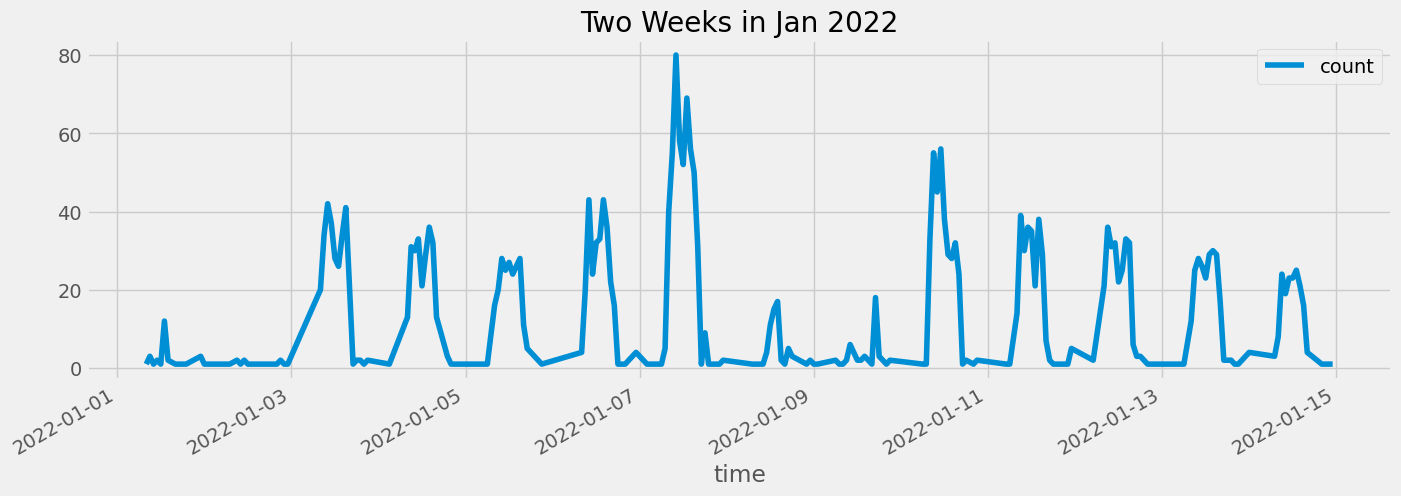

In [75]:
#check out two weeks in Jan 2022 to get a better picture of the data
df_train2.loc[(df_train.index > '01-01-2022') & (df_train2.index < '01-15-2022')].plot(figsize=(15,5), title='Two Weeks in Jan 2022')
plt.show()

### Create more features to add to the model

In [76]:
def create_features_2(df):
    '''
    create time series features based on index date
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df3 = create_features_2(df2)

### Visualize Data By New Features

In [77]:
df3.head(2)
df3.shape

(18336, 7)

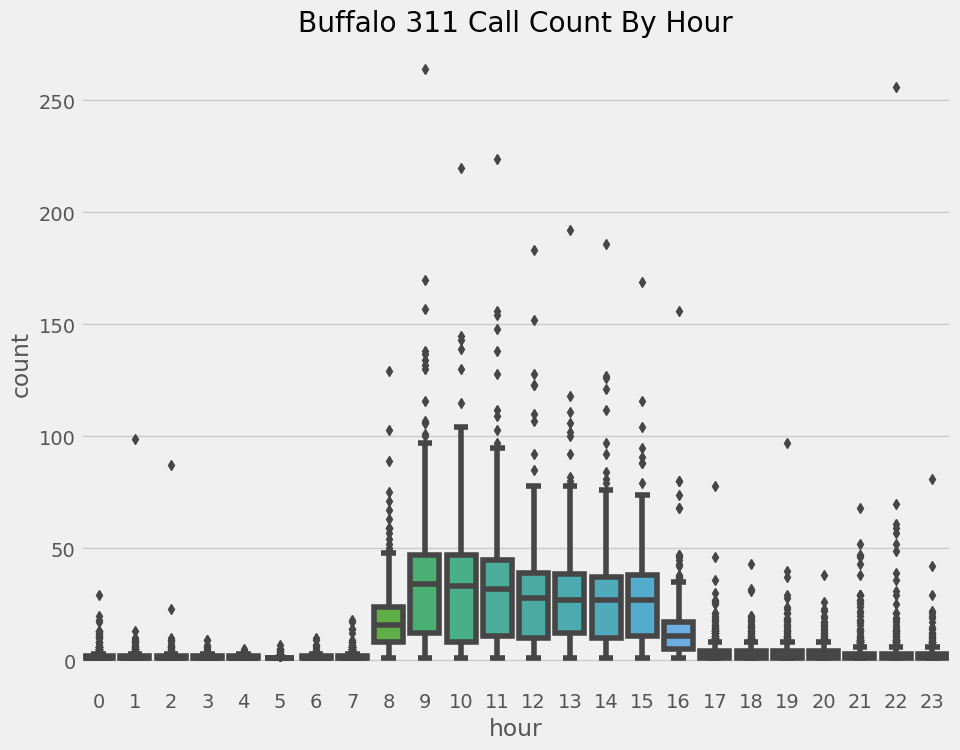

In [78]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df3, x='hour', y='count')
ax.set_title('Buffalo 311 Call Count By Hour')
plt.show()

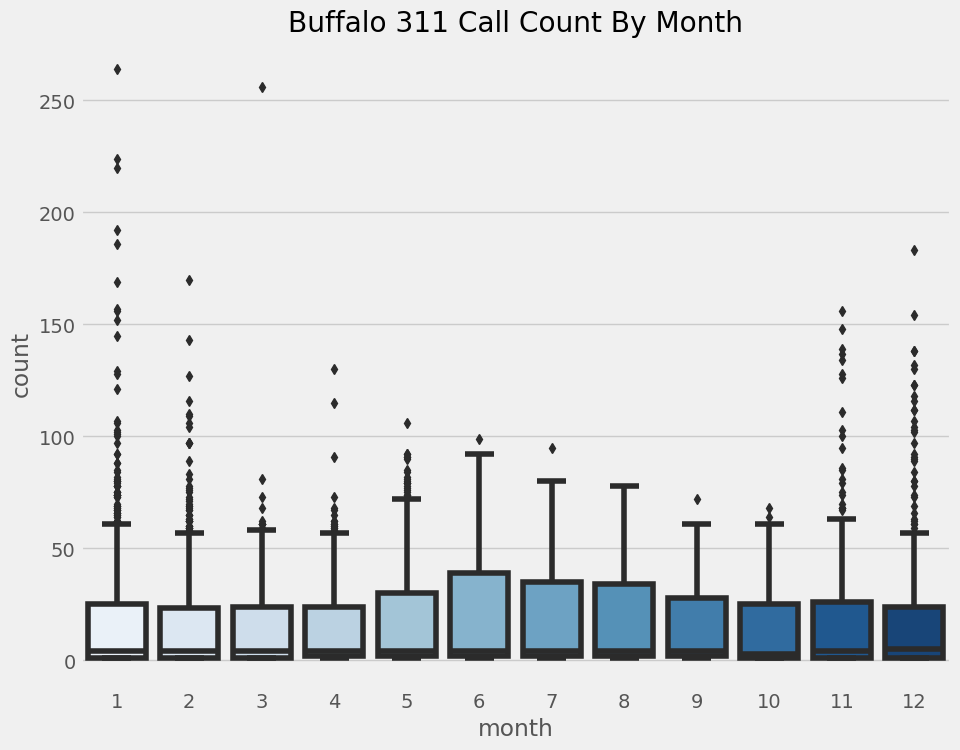

In [79]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df3, x='month', y='count', palette='Blues')
ax.set_title('Buffalo 311 Call Count By Month')
plt.show()

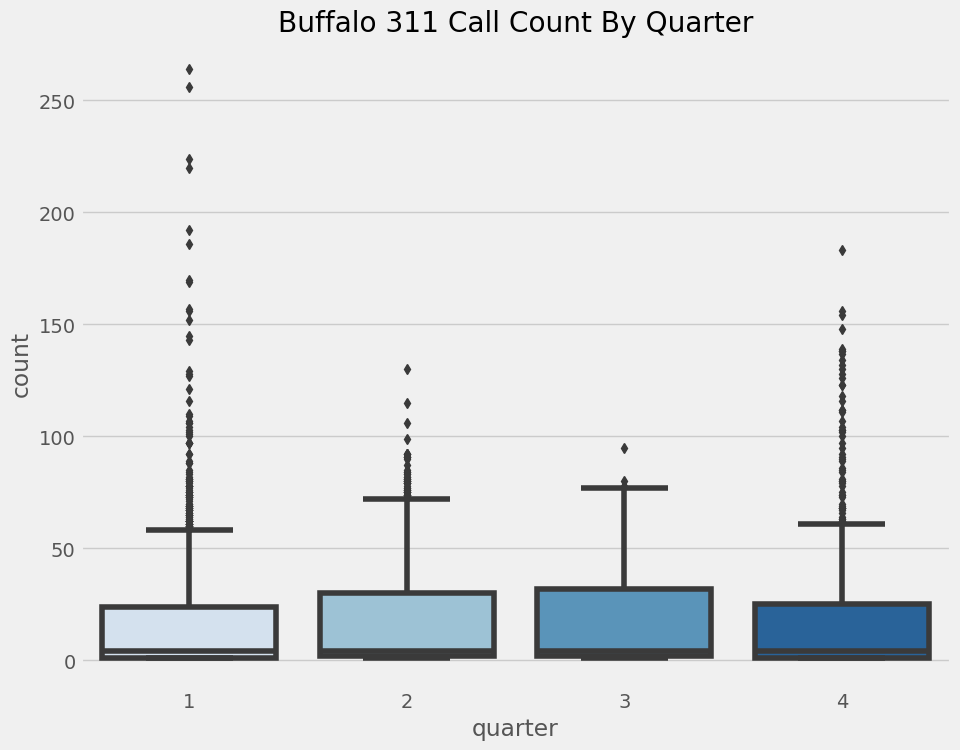

In [80]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df3, x='quarter', y='count', palette='Blues')
ax.set_title('Buffalo 311 Call Count By Quarter')
plt.show()

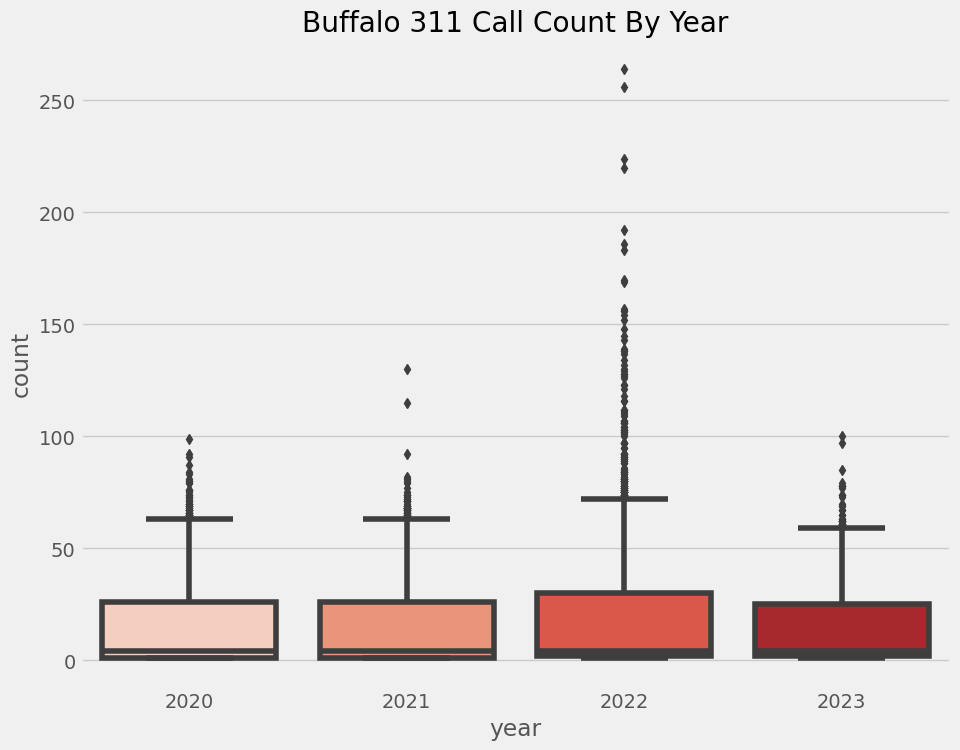

In [81]:
#note that  2023 data is only until 05/04/2023
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df3, x='year', y='count', palette = 'Reds')
ax.set_title('Buffalo 311 Call Count By Year')
plt.show()

##### Seems like 2023 is going to be a blow out year for 311 calls since it is already equal to 2021 call count
##### We are about to be into the 3rd quarter which is historically the largest quarter according to the quarter graph above

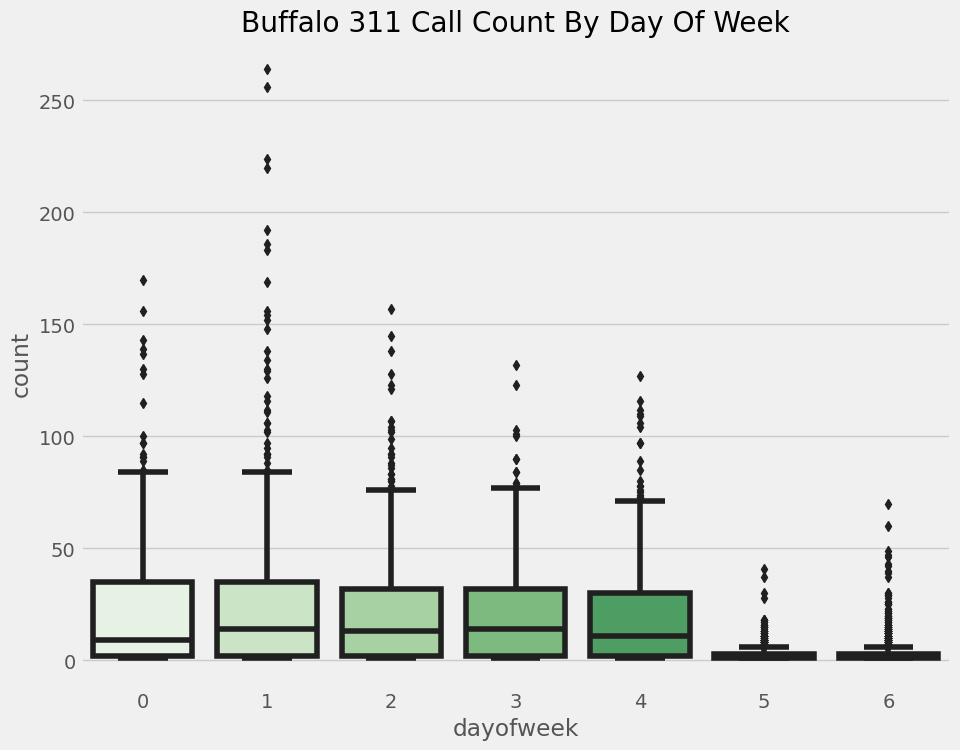

In [82]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df3, x='dayofweek', y='count', palette='Greens')
ax.set_title('Buffalo 311 Call Count By Day Of Week')
plt.show()

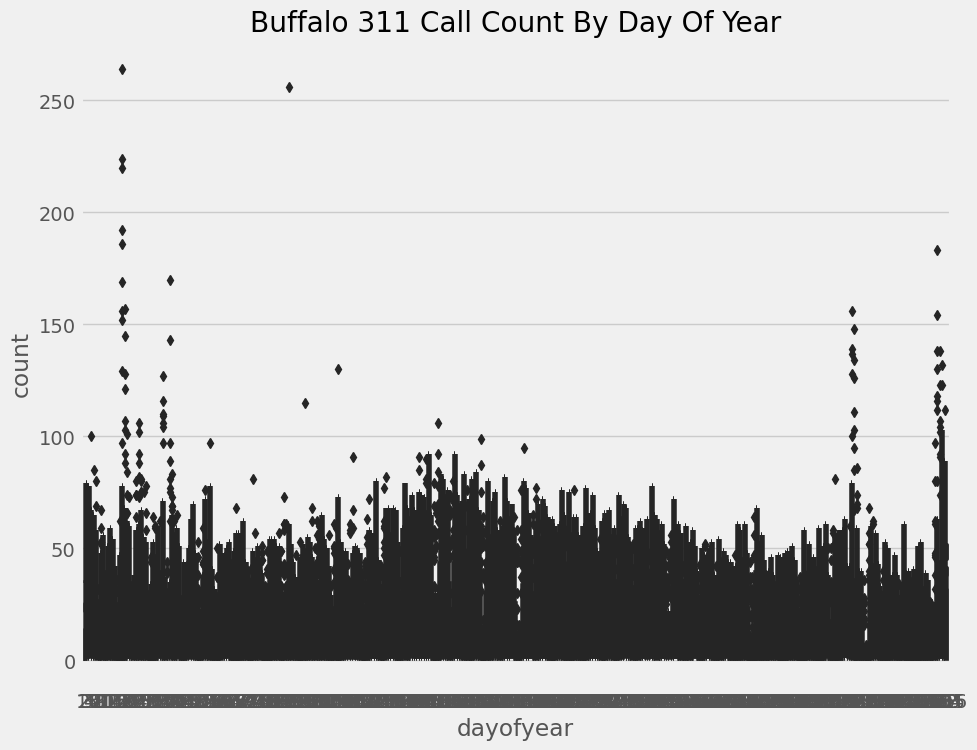

In [83]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df3, x='dayofyear', y='count', palette='Purples')
ax.set_title('Buffalo 311 Call Count By Day Of Year')
plt.show()

### Create XGBOOST Model

In [84]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [85]:
df2.head()

count
time                      
2020-01-10 12:00:00     21
2020-01-10 13:00:00     20
2020-01-10 14:00:00     22
2020-01-10 15:00:00     30
2020-01-10 16:00:00      3

In [86]:
df_train = create_features_2(df_train)
df_test = create_features_2(df_test)

In [87]:
print(df_train.columns)
print(df_test.columns)

Index(['count', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')
Index(['count', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')


In [88]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
target = 'count'

In [89]:
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

In [90]:
#had to lower learning rate to yield better MSE results and have the model not overfit
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,
                      learning_rate = 0.001)
reg.fit(X_train, y_train,
       eval_set = [(X_train, y_train), (X_test, y_test)],
       verbose = 75)

[0]	validation_0-rmse:24.42930	validation_1-rmse:21.25184
[75]	validation_0-rmse:23.02614	validation_1-rmse:19.67356
[150]	validation_0-rmse:21.74553	validation_1-rmse:18.24009
[225]	validation_0-rmse:20.57594	validation_1-rmse:17.05880
[300]	validation_0-rmse:19.51455	validation_1-rmse:15.93974
[375]	validation_0-rmse:18.54768	validation_1-rmse:14.92595
[450]	validation_0-rmse:17.66992	validation_1-rmse:14.00971
[525]	validation_0-rmse:16.87422	validation_1-rmse:13.17353
[600]	validation_0-rmse:16.15464	validation_1-rmse:12.41610
[675]	validation_0-rmse:15.50567	validation_1-rmse:11.74820
[750]	validation_0-rmse:14.91105	validation_1-rmse:11.12767
[825]	validation_0-rmse:14.37133	validation_1-rmse:10.58090
[900]	validation_0-rmse:13.87591	validation_1-rmse:10.11855
[975]	validation_0-rmse:13.41815	validation_1-rmse:9.75119
[999]	validation_0-rmse:13.27996	validation_1-rmse:9.65540


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Feature Importance

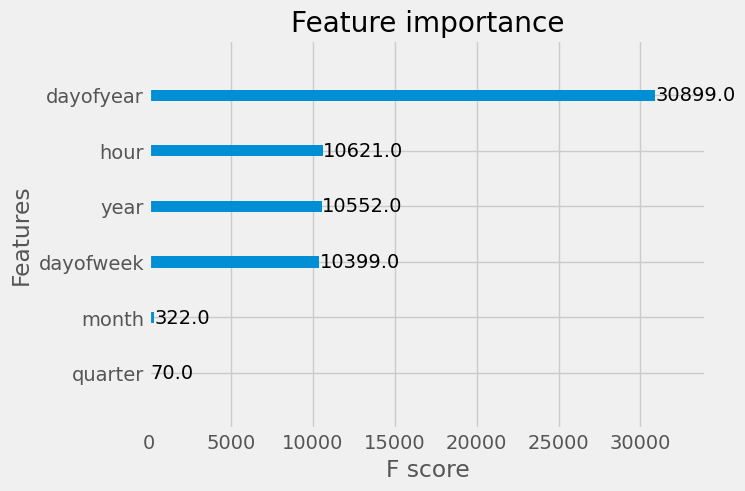

In [93]:
from xgboost import plot_importance
plot_importance(reg)
plt.show()

### Forecast on the Test Data

In [94]:
df_test['prediction'] = reg.predict(X_test)

In [95]:
df3 = df3.merge(df_test[['prediction']], how='left', left_index=True, right_index=True)

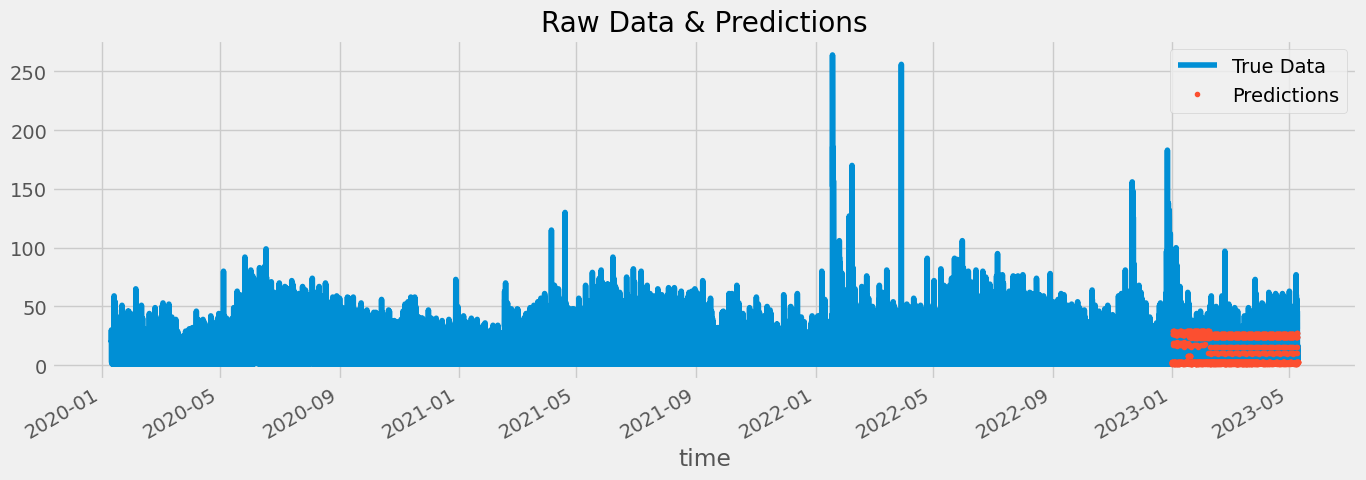

In [96]:
ax = df3[['count']].plot(figsize = (15,5))
df3['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data & Predictions')
plt.show()

### Zoom into the test vs projections
### Feb projection(blue) vs actual(red)

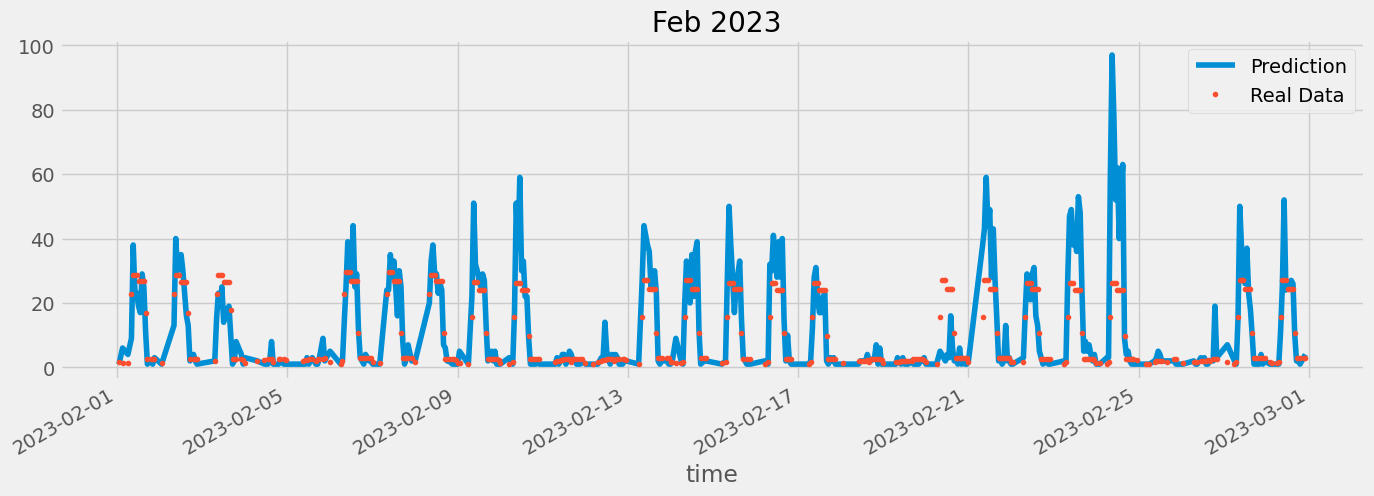

In [97]:
ax = df_test.loc[(df_test.index > '02-01-2023') & (df_test.index < '03-01-2023')]['count'] \
    .plot(figsize=(15,5), title = ' Feb 2023')
df_test.loc[(df_test.index > '02-01-2023') & (df_test.index <'03-01-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Prediction','Real Data' ])
plt.show()

In [98]:
score = np.sqrt(mean_squared_error(df_test['count'], df_test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 9.66


# Calaculate Error for best and worst days

### Worst Projected Days Happened Close to Blizzard 

In [99]:
df_test['error'] = np.abs(df_test[target] - df_test['prediction'])

In [100]:
df_test['date'] = df_test.index.date

In [101]:
#worst projected days happended close to the blizzard
df_test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2023-01-05    19.826350
2023-01-03    17.533686
2023-02-24    17.288375
2023-01-04    16.783298
2023-01-09    14.823705
Name: error, dtype: float64

In [103]:
#best projected days of forecast
df_test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2023-01-15    0.749523
2023-03-25    0.754664
2023-01-29    0.799345
2023-04-30    0.824599
2023-03-18    0.903888
Name: error, dtype: float64

### Outlier Analysis

#### Decided to keep outliers in for the K_fold xgb model

<AxesSubplot: ylabel='Frequency'>

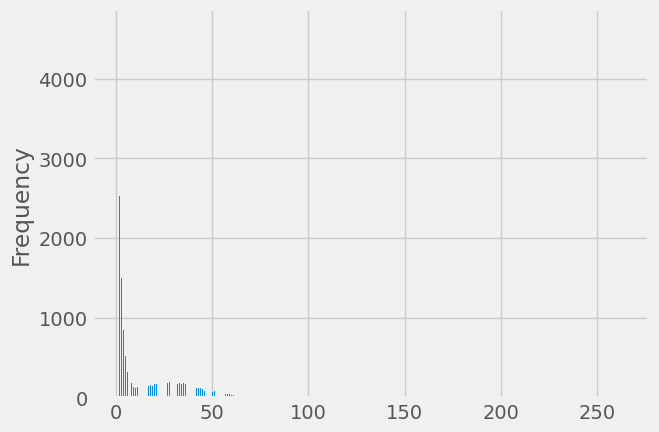

In [104]:
df2['count'].plot(kind='hist', bins=1000)

<AxesSubplot: xlabel='time'>

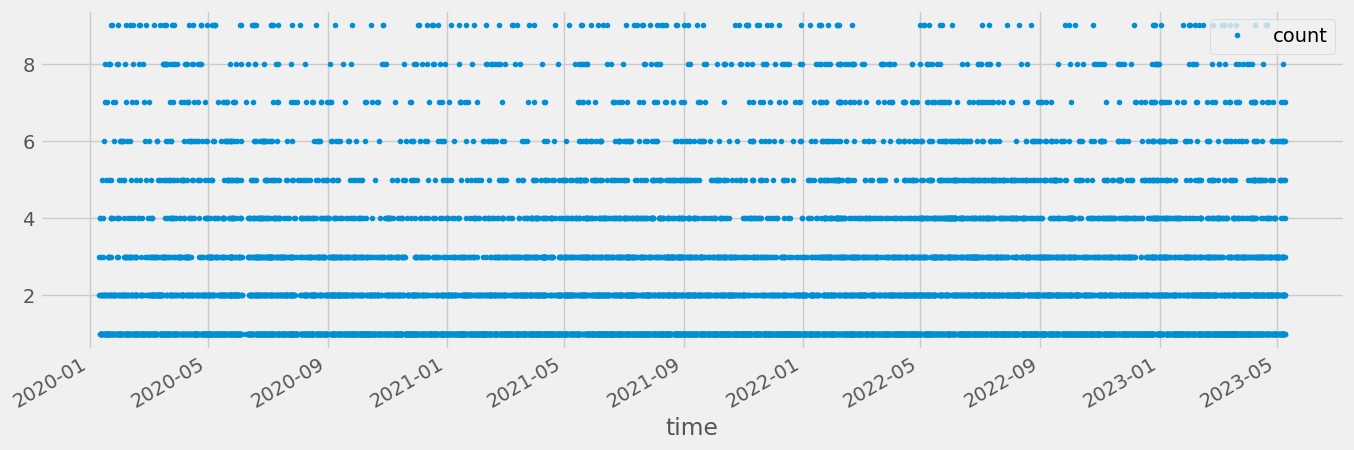

In [105]:
df2.query('count < 10').plot(figsize=(15,5), style='.')

<AxesSubplot: xlabel='time'>

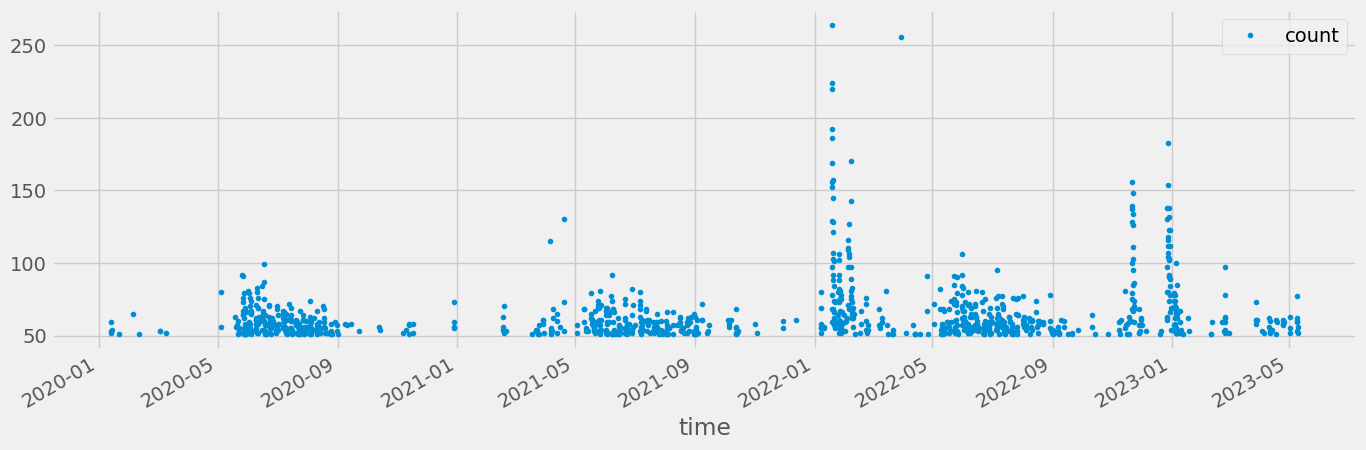

In [106]:
df2.query('count > 50').plot(figsize=(15,5), style='.')

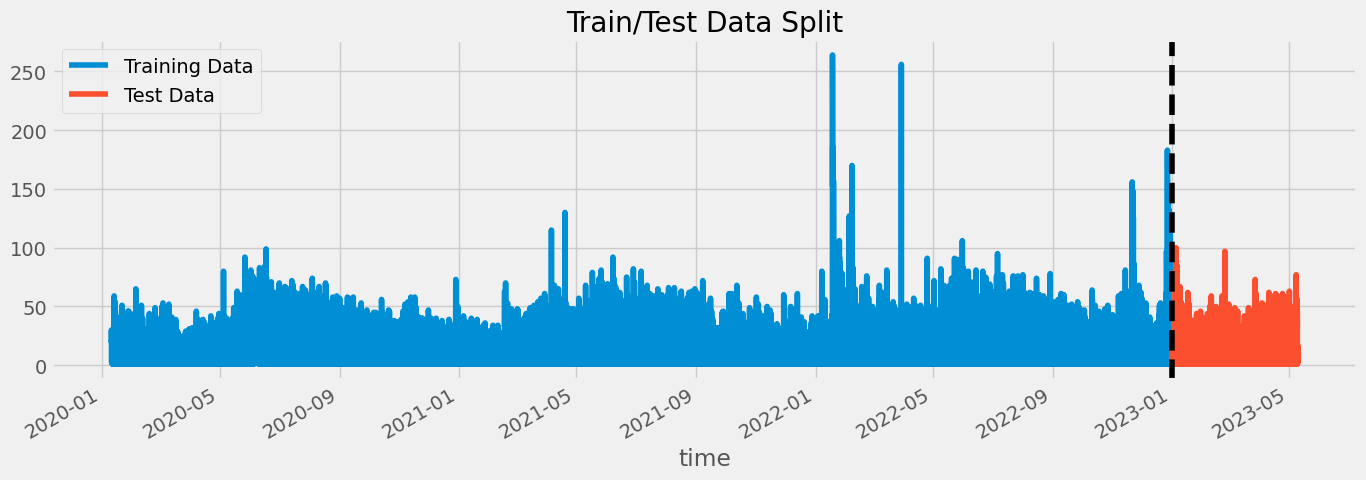

In [107]:
split_date = '1-jan-2023'
df_train3 = df2.loc[df2.index <= split_date].copy()
df_test3 = df2.loc[df2.index > split_date].copy()

fig, ax = plt.subplots(figsize=(15,5))
df_train3.plot(ax=ax, label='Training Data', title='Train/Test Data Split')
df_test3.plot(ax=ax, label='Testing Data')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Data', 'Test Data'])
plt.show()

### Time Series Cross Validation

In [108]:
from sklearn.model_selection import TimeSeriesSplit

In [109]:
df2.shape

(18336, 1)

In [110]:
print(df2.head())
print(df2.tail())

                     count
time                      
2020-01-10 12:00:00     21
2020-01-10 13:00:00     20
2020-01-10 14:00:00     22
2020-01-10 15:00:00     30
2020-01-10 16:00:00      3
                     count
time                      
2023-05-09 19:00:00      5
2023-05-09 20:00:00      1
2023-05-09 21:00:00      2
2023-05-09 22:00:00     17
2023-05-09 23:00:00      2


In [111]:
#tss = TimeSeriesSplit(n_splits=2, test_size=24*365, gap = 24)
tss = TimeSeriesSplit(n_splits=8, test_size=24*60*1, gap = 24)
df4 = df2.sort_index()

In [112]:
df4.head()

count
time                      
2020-01-10 12:00:00     21
2020-01-10 13:00:00     20
2020-01-10 14:00:00     22
2020-01-10 15:00:00     30
2020-01-10 16:00:00      3

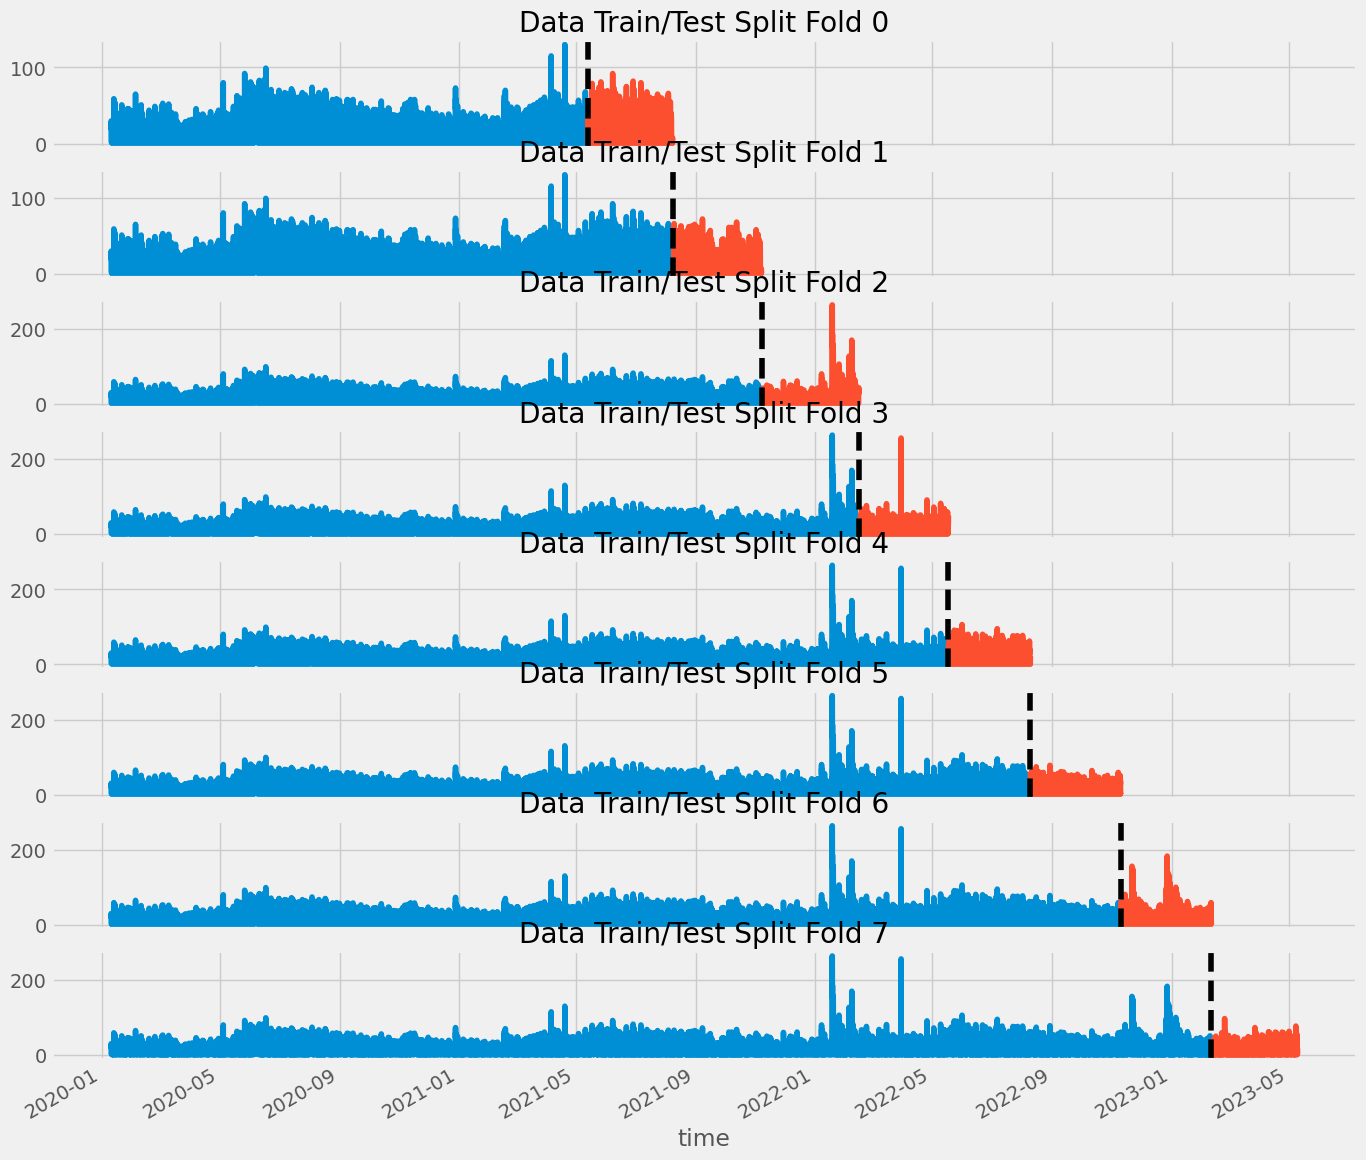

In [113]:
fig, axs = plt.subplots(8, 1, figsize=(15,15),
                            sharex = True)

fold = 0

for train_idx, val_idx in tss.split(df4):
    train = df4.iloc[train_idx]
    test = df4.iloc[val_idx]
    train['count'].plot(ax=axs[fold],
                        label='Training Set', 
                        title=f'Data Train/Test Split Fold {fold}')
    test['count'].plot(ax=axs[fold],
                       label = 'Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold +=1

In [116]:
# make function for new time features 
def create_features4(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df4 = create_features4(df4)

In [117]:
df4.head()

count  hour  dayofweek  quarter  month  year  dayofyear  \
time                                                                           
2020-01-10 12:00:00     21    12          4        1      1  2020         10   
2020-01-10 13:00:00     20    13          4        1      1  2020         10   
2020-01-10 14:00:00     22    14          4        1      1  2020         10   
2020-01-10 15:00:00     30    15          4        1      1  2020         10   
2020-01-10 16:00:00      3    16          4        1      1  2020         10   

                     dayofmonth  weekofyear  
time                                         
2020-01-10 12:00:00          10           2  
2020-01-10 13:00:00          10           2  
2020-01-10 14:00:00          10           2  
2020-01-10 15:00:00          10           2  
2020-01-10 16:00:00          10           2

### Lag Features

In [118]:
# make lag feature function
def add_lags(df):
    target_map = df['count'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    return df

In [ ]:
#test lags function
#df4 = add_lags(df)

In [ ]:
#check df after lags function test
#df4.tail()

### Train Using Cross Validation

In [119]:
tss = TimeSeriesSplit(n_splits=8, test_size=24*60*1, gap = 24)
df4 = df2.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df4):
    train = df4.iloc[train_idx]
    test = df4.iloc[val_idx]
    
    train = create_features4(train)
    test = create_features4(test)
    
    train = add_lags(train)
    test = add_lags(test)
    
    FEATURES4 = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2', 'lag3']
    TARGET4 = 'count'
    
    X_train = train[FEATURES4]
    y_train = train[TARGET4]

    X_test = test[FEATURES4]
    y_test = test[TARGET4]
    
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=100000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.1)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=10000)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
    

[15:49:23] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:20.28806	validation_1-rmse:25.23168
[365]	validation_0-rmse:6.34963	validation_1-rmse:9.52946
[15:49:23] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:21.08501	validation_1-rmse:20.03218
[495]	validation_0-rmse:6.41239	validation_1-rmse:7.29066
[15:49:24] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:20.86114	validation_1-rmse:29.95618
[163]	validation_0-rmse:7.21473	validation_1-rmse:21.61451
[15:49:25] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear

In [120]:
print(f'Scores across all folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Scores across all folds 12.4270
Fold scores:[9.432683974684368, 7.263089487308816, 21.508818615589814, 11.799599285719262, 11.072779306904335, 7.013240970100097, 19.336143148373846, 11.989809586405414]


### Retrain model on all training data to prepare for forecasting the future

In [121]:
#retrain all data to prepare for forecasting
#still leverage all data for forecast prediction
#switchedn_estimator to 1500 because the model still seemed like it was getting better
#also moved the learning rate down

df4 = create_features4(df4)
df4 = add_lags(df4)

FEATURES4 = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2', 'lag3']
TARGET4 = 'count'

X_all = df4[FEATURES4]
y_all = df4[TARGET4]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       #n_estimators=25000,
                       n_estimators=100000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       #learning_rate=0.0001) # LEARNING FASTER SEEMS TO BOOST PERFORMANCE OF THE MODEL
                       learning_rate=0.1)

reg.fit(X_all, y_all,
       eval_set=[(X_all, y_all)],
       verbose=10000)

[15:50:49] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:22.43720
[10000]	validation_0-rmse:4.73683
[20000]	validation_0-rmse:4.05477
[30000]	validation_0-rmse:3.67679
[40000]	validation_0-rmse:3.42238
[50000]	validation_0-rmse:3.23311
[60000]	validation_0-rmse:3.07159
[70000]	validation_0-rmse:2.93679
[80000]	validation_0-rmse:2.82711
[90000]	validation_0-rmse:2.72784
[99999]	validation_0-rmse:2.63702


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

###  Lowered RMSE when I change the n_estimator to 100K and move the learning rate down

### Forecasting The Future

In [122]:
#find max value and set rage from last date 
FurtueStartDate = df4.index.max()
'''
df_day['time'] = pd.to_datetime(df_day['time']).dt.strftime('%Y-%m-%d')
'''
#FurtueStartDate = FurtueStartDate.dt.strftime('%Y-%m-%d')
FurtueStartDate

Timestamp('2023-05-09 23:00:00')

In [123]:
#can't project longer than the smallest lag
future = pd.date_range('2023-05-04', '11/02/2023' , freq='1h')
future_df = pd.DataFrame(index=future)

In [124]:
future_df['is_future'] = True
df4['is_future'] = False
df_and_future = pd.concat([df4, future_df])

In [125]:
df_and_future = create_features4(df_and_future)
df_and_future = add_lags(df_and_future)

In [126]:
df_and_future

count  hour  dayofweek  quarter  month  year  dayofyear  \
2020-01-10 12:00:00   21.0    12          4        1      1  2020         10   
2020-01-10 13:00:00   20.0    13          4        1      1  2020         10   
2020-01-10 14:00:00   22.0    14          4        1      1  2020         10   
2020-01-10 15:00:00   30.0    15          4        1      1  2020         10   
2020-01-10 16:00:00    3.0    16          4        1      1  2020         10   
...                    ...   ...        ...      ...    ...   ...        ...   
2023-11-01 20:00:00    NaN    20          2        4     11  2023        305   
2023-11-01 21:00:00    NaN    21          2        4     11  2023        305   
2023-11-01 22:00:00    NaN    22          2        4     11  2023        305   
2023-11-01 23:00:00    NaN    23          2        4     11  2023        305   
2023-11-02 00:00:00    NaN     0          3        4     11  2023        306   

                     dayofmonth  weekofyear  lag1  lag2  lag3  is_future  
2020-01-10 12:00:00          10           2   NaN   NaN   NaN      False  
2020-01-10 13:00:00          10           2   NaN   NaN   NaN      False  
2020-01-10 14:00:00          10           2   NaN   NaN   NaN      False  
2020-01-10 15:00:00          10           2   NaN   NaN   NaN      False  
2020-01-10 16:00:00          10           2   NaN   NaN   NaN      False  
...                         ...         ...   ...   ...   ...        ...  
2023-11-01 20:00:00           1          44   3.0   4.0   NaN       True  
2023-11-01 21:00:00           1          44   1.0   2.0   1.0       True  
2023-11-01 22:00:00           1          44   1.0   NaN   1.0       True  
2023-11-01 23:00:00           1          44   2.0   NaN   1.0       True  
2023-11-02 00:00:00           2          44   NaN   NaN   NaN       True  

[22705 rows x 13 columns]

In [127]:
#may need to go in and fill in lag Nan's with ffill
future_with_features = df_and_future.query('is_future').copy()
future_with_features

count  hour  dayofweek  quarter  month  year  dayofyear  \
2023-05-04 00:00:00    NaN     0          3        2      5  2023        124   
2023-05-04 01:00:00    NaN     1          3        2      5  2023        124   
2023-05-04 02:00:00    NaN     2          3        2      5  2023        124   
2023-05-04 03:00:00    NaN     3          3        2      5  2023        124   
2023-05-04 04:00:00    NaN     4          3        2      5  2023        124   
...                    ...   ...        ...      ...    ...   ...        ...   
2023-11-01 20:00:00    NaN    20          2        4     11  2023        305   
2023-11-01 21:00:00    NaN    21          2        4     11  2023        305   
2023-11-01 22:00:00    NaN    22          2        4     11  2023        305   
2023-11-01 23:00:00    NaN    23          2        4     11  2023        305   
2023-11-02 00:00:00    NaN     0          3        4     11  2023        306   

                     dayofmonth  weekofyear  lag1  lag2  lag3  is_future  
2023-05-04 00:00:00           4          18   NaN   NaN   NaN       True  
2023-05-04 01:00:00           4          18   NaN   NaN   NaN       True  
2023-05-04 02:00:00           4          18   NaN   NaN   NaN       True  
2023-05-04 03:00:00           4          18   NaN   NaN   NaN       True  
2023-05-04 04:00:00           4          18   NaN   1.0   NaN       True  
...                         ...         ...   ...   ...   ...        ...  
2023-11-01 20:00:00           1          44   3.0   4.0   NaN       True  
2023-11-01 21:00:00           1          44   1.0   2.0   1.0       True  
2023-11-01 22:00:00           1          44   1.0   NaN   1.0       True  
2023-11-01 23:00:00           1          44   2.0   NaN   1.0       True  
2023-11-02 00:00:00           2          44   NaN   NaN   NaN       True  

[4369 rows x 13 columns]

### Run Predict

In [128]:
FEATURES4 = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2', 'lag3']
TARGET4 = 'count'

#run trained model on features in future df
#save in new column called pred
future_with_features['pred'] = reg.predict(future_with_features[FEATURES4])

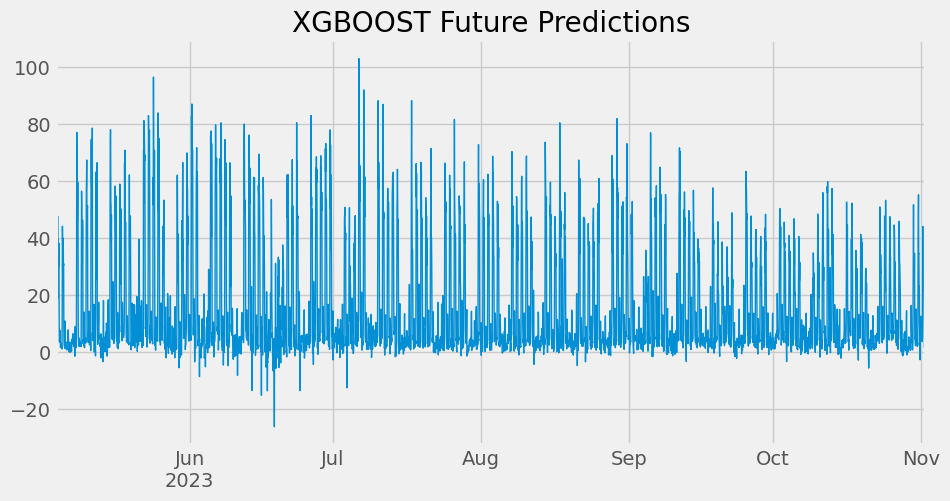

In [129]:
import matplotlib.pyplot as plt

future_with_features['pred'].plot(figsize = (10,5),
                                  #color= 'Blue',
                                  color= color_pal[0],
                                  ms=1, 
                                  lw=1,
                                  title='XGBOOST Future Predictions')
plt.show()

### Save & Load XGBOOST model

In [130]:
reg.save_model('311XGB_model.json')

In [131]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('311XGB_model.json')

### Run saved model on future features

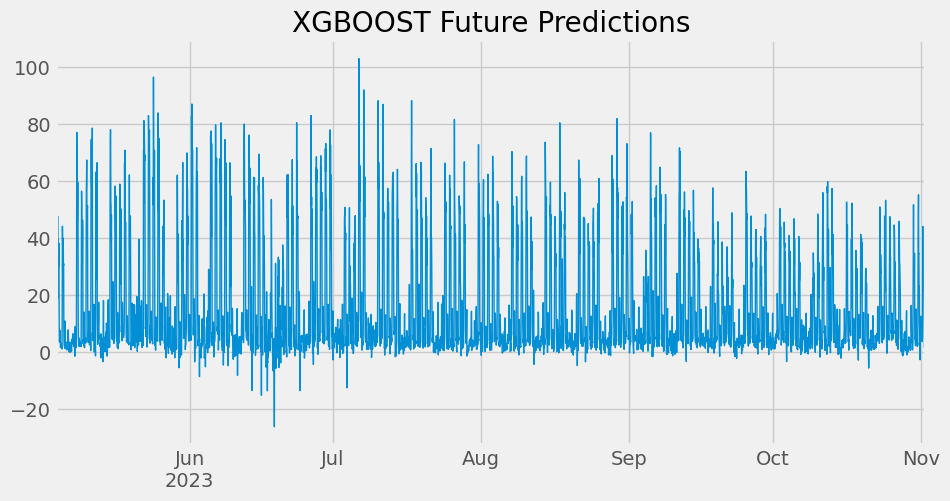

In [132]:
#run saved model under reg_new and plot results
future_with_features['pred'] = reg_new.predict(future_with_features[FEATURES4])

future_with_features['pred'].plot(figsize = (10,5),
                                  #color= 'Blue',
                                  color= color_pal[0],
                                  ms=1, 
                                  lw=1,
                                  title='XGBOOST Future Predictions')
plt.show()

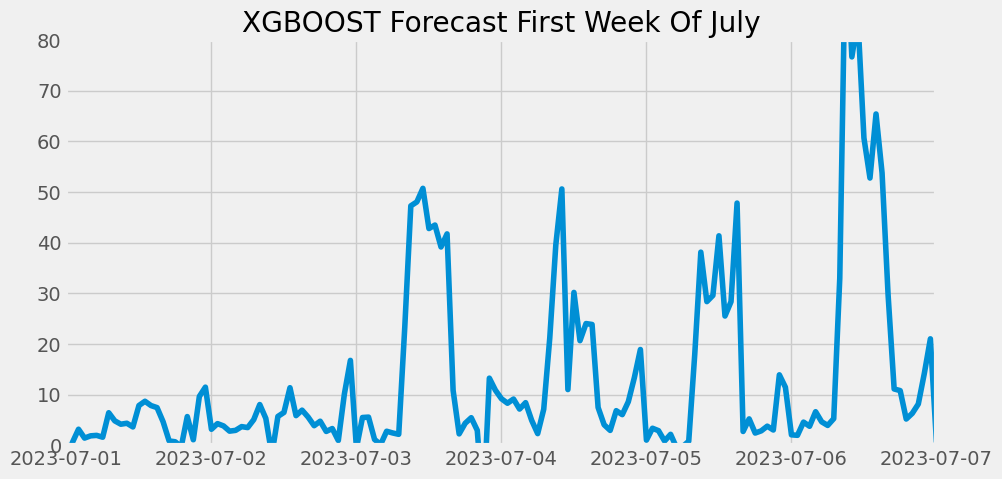

In [133]:
#zoomed in plot of forecast for upcoming week; first week of may
import datetime
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(future_with_features.index, future_with_features['pred'])
#fig = future_with_features['pred'].plot(future_with_features['pred'], ax= ax)
ax.set_xlim([datetime.date(2023, 7, 1), datetime.date(2023, 7, 7)])
ax.set_ylim(0,80)
ax.set_title('XGBOOST Forecast First Week Of July')
plt.show()


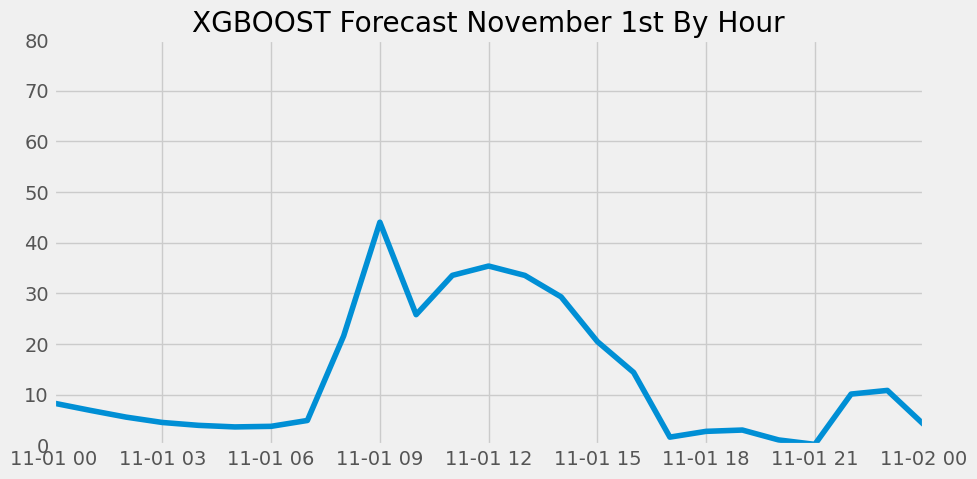

In [134]:
#zoomed in plot of forecast for upcoming week; first week of may
import datetime
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(future_with_features.index, future_with_features['pred'])
#fig = future_with_features['pred'].plot(future_with_features['pred'], ax= ax)
ax.set_xlim([datetime.date(2023, 11, 1), datetime.date(2023, 11, 2)])
ax.set_ylim(0,80)
ax.set_title('XGBOOST Forecast November 1st By Hour')
plt.show()

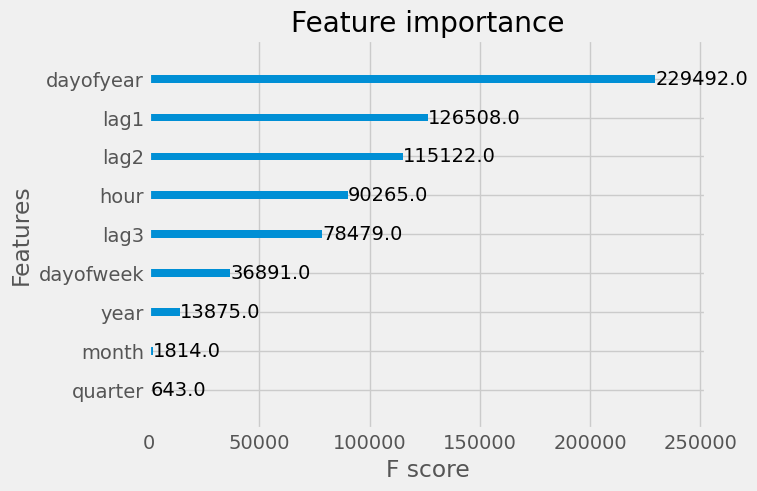

In [135]:
from xgboost import plot_importance
plot_importance(reg_new)
plt.show()

### AMIRA
Auto Regression, , Integarted(differencing) , Moving Average

##### can not figure out how to do hourly, switched to daily data

In [136]:
!pip3 install pmdarima

<AxesSubplot: xlabel='time'>

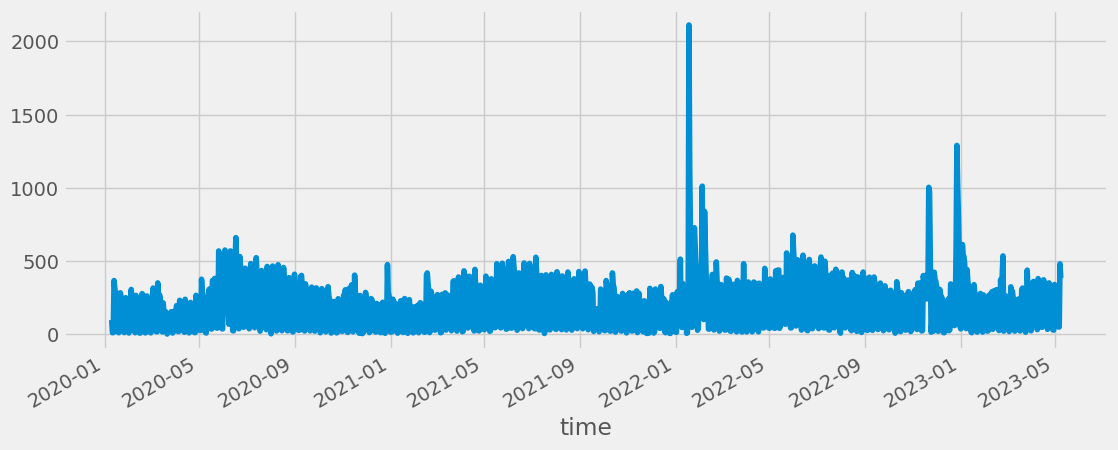

In [150]:
df_day['count'].plot(figsize=(12,5))

### Check For Stationarity

In [141]:
!pip install statsmodels

In [142]:
#import statsmodels.api as sm
import statsmodels.api
import statsmodels.formula.api as smf

In [143]:
from statsmodels.tsa.stattools import adfuller

In [144]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print('1. ADF : ', dftest[0])
    print('2. P-Value : ', dftest[1])
    print('3. Num Of Lags : ', dftest[2])
    print('4. Num Of Observations Used For ADF Regression and Critical Values Calculation : ', dftest[3])
    print('5. Critical Values : ')
    for key, val in dftest[4].items():
        print('\t', key, ':',val)

In [151]:
# P-Value is probability and should be as low as possible
#the smaller the better P-Value
#small value means teh data set is stationary
ad_test(df_day['count'])

1. ADF :  -4.7528316341012635
2. P-Value :  6.688647512497074e-05
3. Num Of Lags :  22
4. Num Of Observations Used For ADF Regression and Critical Values Calculation :  1189
5. Critical Values : 
	 1% : -3.435861752677197
	 5% : -2.8639738850277796
	 10% : -2.568065847341873


In [148]:
from pmdarima import auto_arima
# Ignore  warnings
import warnings
warnings.filterwarnings('ignore')

### make predictions on future values

### Predict the future

In [152]:
df_day.head()

count
time             
2020-01-10     98
2020-01-11     12
2020-01-12     13
2020-01-13    368
2020-01-14    316

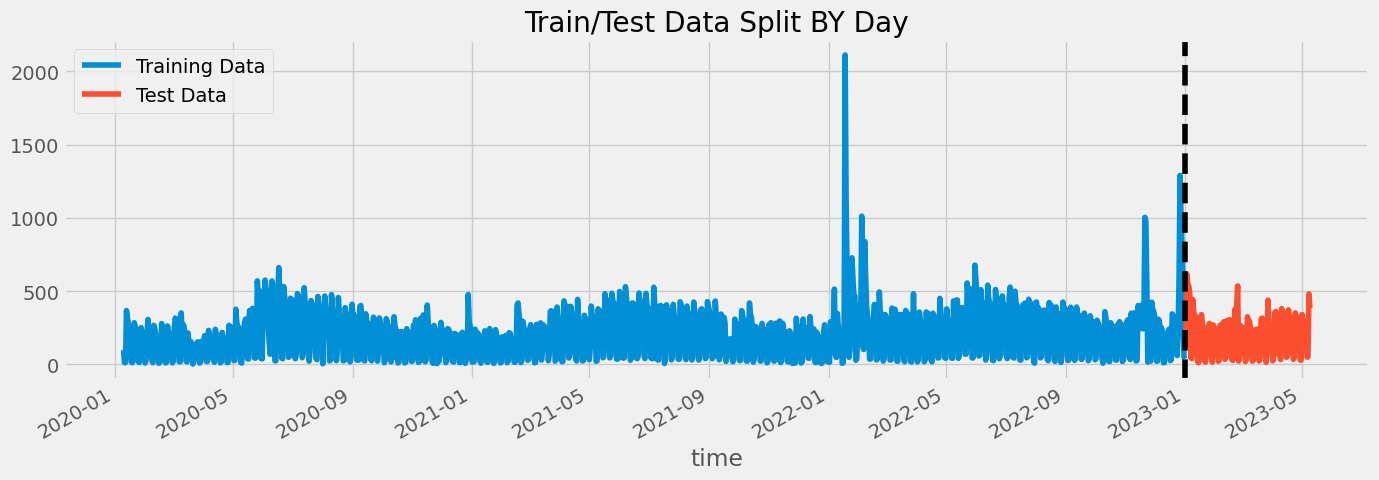

In [153]:
split_date = '1-jan-2023'
df_train_day = df_day.loc[df_day.index <= split_date].copy()
df_test_day = df_day.loc[df_day.index > split_date].copy()

fig, ax = plt.subplots(figsize=(15,5))
df_train_day.plot(ax=ax, label='Training Data', title='Train/Test Data Split BY Day')
df_test_day.plot(ax=ax, label='Testing Data')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Data', 'Test Data'])
plt.show()

In [154]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [155]:
import statsmodels.api
import statsmodels.formula.api as smf

In [156]:
stepwise_fit = auto_arima(df_day['count'],
                          trace=True,
                          supress_warnings=True)

stepwise_fit.summary()  

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15485.928, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16082.799, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16076.953, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15868.409, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16080.802, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15577.259, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15544.333, Time=0.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15334.875, Time=1.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15546.470, Time=1.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=15311.143, Time=1.53 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=15164.604, Time=1.69 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=15301.116, Time=1.93 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=15108.060, Time=1.90 sec
 ARIMA(5,1,2)(0,0,0)[0] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1212
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -7450.837
Date:                Wed, 10 May 2023   AIC                          14923.674
Time:                        16:08:20   BIC                          14979.765
Sample:                             0   HQIC                         14944.793
                               - 1212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9527      0.061     15.629      0.000       0.833       1.072
ar.L2         -1.5558      0.046    -33.884      0.000      -1.646      -1.466
ar.L3          1.0378      0.081     12.746      0.000       0.878       1.197
ar.L4         -1.1024      0.049    -22.362      0.000      -1.199      -1.006
ar.L5          0.1677      0.053      3.145      0.002       0.063       0.272
ma.L1         -1.5405      0.053    -28.943      0.000      -1.645      -1.436
ma.L2          1.8972      0.057     33.325      0.000       1.786       2.009
ma.L3         -1.8915      0.057    -33.031      0.000      -2.004      -1.779
ma.L4          1.4121      0.062     22.934      0.000       1.291       1.533
ma.L5         -0.6891      0.036    -19.358      0.000      -0.759      -0.619
sigma2      1.568e+04    237.142     66.111      0.000    1.52e+04    1.61e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            210261.66
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             4.43
Prob(H) (two-sided):                  0.03   Kurtosis:                        66.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [157]:
#use order from best order in the step above

model_day=sm.tsa.ARIMA(df_train_day['count'], order=(5,1,5))
model_day=model_day.fit()
model_day.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                 1084
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -6684.911
Date:                Wed, 10 May 2023   AIC                          13391.822
Time:                        16:08:47   BIC                          13446.684
Sample:                             0   HQIC                         13412.592
                               - 1084                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9872      0.059     16.838      0.000       0.872       1.102
ar.L2         -1.5865      0.045    -35.588      0.000      -1.674      -1.499
ar.L3          1.0828      0.080     13.602      0.000       0.927       1.239
ar.L4         -1.1353      0.047    -23.966      0.000      -1.228      -1.042
ar.L5          0.1974      0.053      3.742      0.000       0.094       0.301
ma.L1         -1.5795      0.052    -30.481      0.000      -1.681      -1.478
ma.L2          1.9451      0.057     33.879      0.000       1.833       2.058
ma.L3         -1.9274      0.059    -32.557      0.000      -2.043      -1.811
ma.L4          1.4612      0.060     24.198      0.000       1.343       1.580
ma.L5         -0.7163      0.038    -18.685      0.000      -0.791      -0.641
sigma2      1.612e+04    250.719     64.298      0.000    1.56e+04    1.66e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            195507.26
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                             4.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Make Predictions On Test Set

In [158]:
start=len(df_train_day)
end=len(df_train_day)+len(df_test_day)-1
pred_day=model_day.predict(start=start, end=end, typ='levels')
#print(pred) # dates did not appear do use next line of code
pred_day.index=df_day.index[start:end+1]
print(pred_day)

time
2023-01-02    479.428567
2023-01-03    674.749061
2023-01-04    604.407490
2023-01-05    557.103754
2023-01-06    398.781992
                 ...    
2023-05-05    469.493291
2023-05-06    312.357834
2023-05-07    315.081241
2023-05-08    506.594428
2023-05-09    507.856525
Name: predicted_mean, Length: 128, dtype: float64


<AxesSubplot: xlabel='time'>

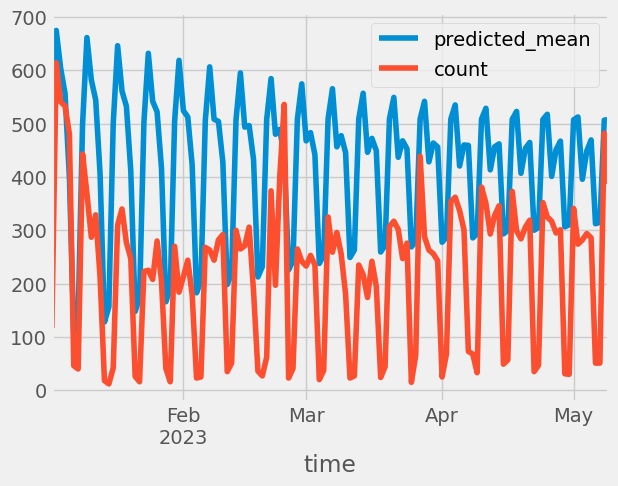

In [159]:
pred_day.plot(legend=True)
df_test_day['count'].plot(legend=True)

In [160]:
df_day['count'].mean()

229.16006600660066

In [161]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_day=sqrt(mean_squared_error(pred_day, df_test_day['count']))
rmse_day

224.44111330608987

Make predictions

In [162]:
#Fit model on all df_day
model_day = sm.tsa.ARIMA(df_day['count'], order=(5,0,5))
model_day=model_day.fit()
df_day.tail() # predict into the future after training

count
time             
2023-05-05    286
2023-05-06     51
2023-05-07     51
2023-05-08    482
2023-05-09    387

In [163]:
index_future_dates=pd.date_range(start='2023-05-09', end='2023-12-31', freq='D')
pred_day=model_day.predict(start=len(df_day), end=len(df_day)+(236), type='levels').rename('ARIMA Predictions BY Day')
pred_day.index=index_future_dates
print(pred_day)

2023-05-09    297.317413
2023-05-10    336.257542
2023-05-11    253.195036
2023-05-12     48.160946
2023-05-13    112.191123
                 ...    
2023-12-27    262.186749
2023-12-28    227.061904
2023-12-29    157.228323
2023-12-30    188.266458
2023-12-31    265.360301
Freq: D, Name: ARIMA Predictions BY Day, Length: 237, dtype: float64


In [164]:
pred_day.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 237 entries, 2023-05-09 to 2023-12-31
Freq: D
Series name: ARIMA Predictions BY Day
Non-Null Count  Dtype  
--------------  -----  
237 non-null    float64
dtypes: float64(1)
memory usage: 3.7 KB


<AxesSubplot: >

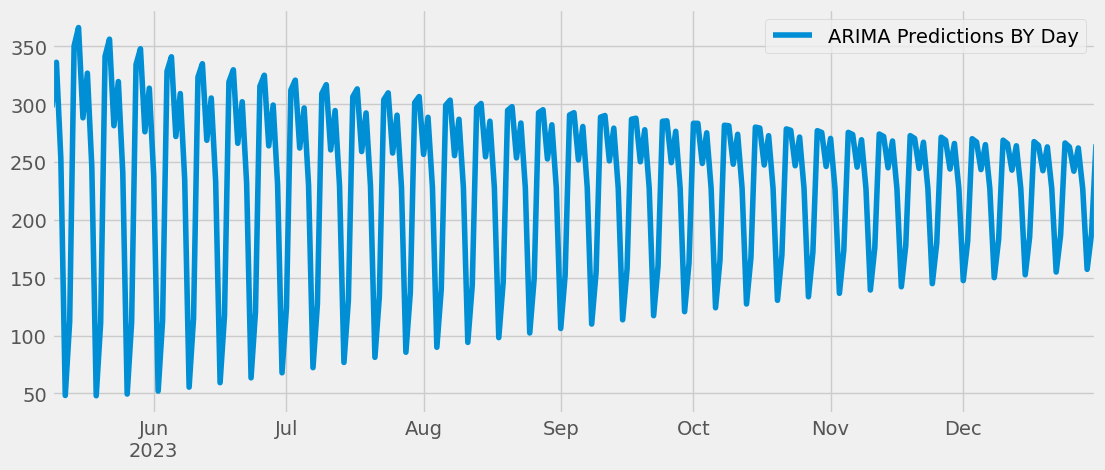

In [165]:
pred_day.plot(figsize=(12,5),legend=True)